<a href="https://colab.research.google.com/github/johnzelson/local-nonprofit-colab/blob/main/S1_IRS_BMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook processes a [Business Master File extract (BMF)](https://www.irs.gov/charities-non-profits/exempt-organizations-business-master-file-extract-eo-bmf) from [IRS](www.irs.gov) of all the active Nonprofits in NY and creates a dataframe of nonprofits in a local area with various code lookups added.

The IRS creates these extracts from Form 1023 - the form that organizations file to become recognized as a federally recognized nonprofit - along some key info from the latest annual tax submmission (Form 990-series).

This processing is the first step in a series of notebooks and streamlit app to analyze nonprofits in local area.  I was interested in Cortland, but the steps should be repeatable for other areas.



# Tech Notes

This first step (S1 IRS BMF) in a series of processing notebooks, loads BMF into a Pandas dataframe, adds human-readable definitions/lookups from spreadsheets of definitions, saves tidy dataframe of just local area nonprofits, and then does some plotting.

All data is on google drive, with locations assumed in code.  There is some configurability, but setting that up is future .


S1 IRS BMF uses these files

| In Files          | Description         |
| ---------------- | -------------------- |
| eo_ny.csv        |   IRS BMF File       |
| NTEE Code.csv    |   Definitions of NTEE Codes    |
| IRS_Lookups.csv    |  Definitions of IRS Codes   |
| IRS_Activity_Codes.csv | Defs of IRS Activity Codes |


|     Out Files          |     Description       |
| ---------------------  | --------------------- |
| np_ny_p_df.csv         | Dataframe of processed BMF      |
|np_cortland_p_df.csv    | Orgs with Postal zip 13045
|np_cort_10mile_p_df.csv | Zip within 10mi of Cortland |
|np_cort_co_df.to_csv    | Zip in county        |
| cities_df.csv          | Cities in NY         |


The out files are used in successive notebooks to build dataset for streamlit/web app.




# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#TODO: create a configuration seciton -- not implemented

# base folder for retrieving raw data
data_dir = '/content/drive/My Drive/irs_data/'

# folder for writing processed data
proc_dir = '/content/drive/My Drive/irs_processed/'


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import csv
import math

#TODO: remove, as currency formatting is mostly done in presentation
# for formatting currency
import locale
locale.setlocale( locale.LC_ALL, '' )

'en_US.UTF-8'

#1 Load NY Orgs

IRS offers [BMF by state and region](https://www.irs.gov/charities-non-profits/exempt-organizations-business-master-file-extract-eo-bmf).  I just needed one file, EO_NY.csv, and downloaded manually.  (July 2024)

In [8]:
# --- Load IRS Master File of Active NPs in NY ---
# Gets all "active" NPs with latest Tax Return, Form 990-series summary.


# Specify the data type for each column
dtype = {"CLASSIFICATION": str,
         "EIN" : str,
         "ACTIVITY" : str,
         "AFFILIATION" : str,
         "ORGANIZATION" : str,
         "FOUNDATION" : str,
         "NTEE_CD" : str,
         "RULING" : str,
         "ZIP" : str,
         "TAX_PERIOD" : str,
         "GROUP" : str,
         }

df = pd.read_csv('/content/drive/My Drive/irs_data/eo_ny.csv', dtype=dtype)

# add the panda id for each org. carry this id for whole process
df["p_org_id"] = df.index
#TODO: rename to np_org_id?

# Display the DataFrame
df.head()


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4


In [9]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  object 
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  object 
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  object 
 10  CLASSIFICATION    119765 non-null  object 
 11  RULING            119765 non-null  object 
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  object 
 14  ACTIVITY          119765 non-null  object 
 15  ORGANIZATION      119765 non-null  object 
 16  STATUS            11

#2 Load BMF Code, add to dataframe

## Load IRS Lookups

The IRS BMF is full of codes.  In some cases, codes are concatenated into one field. Those codes need to be extracted, then plain English descriptions are  looked up.  I created code lookup spreadsheets which are used to add descriptions into dataframes.
(TODO: add data sources for spreadsheets)



In [12]:
#  --- load ntee codes into dict ---
# https://urbaninstitute.github.io/nccs-legacy/ntee/ntee-history.html

ntee = {}
eo = {}

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/NCCS_NTEE.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}" )
      ntee[row[0]] = [row[1], row[2]]


In [13]:
# Other BMF Lookups
# Instead of having multiple lookup sheets, piled into
# Loaded into dict of dicts

#TODO: the full definitions, verbatim, of codes lookups are too long for graph axis, need short desc

# Nested dictionary, ends up like this
#bmf = { 'INCOME_CD': {'code1': 'XX', 'codevalue1': '19', 'code2': 'YY', 'codevalue2': '25' ...},
#        'ASSET_CD': {'code1': 'YY', 'codevalue1': '25'}


bmf = {}
bmf_set = set() # get each unique BMF field/column name
all_rows = []

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/IRS_BMF_Lookups.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}  3 {row[3]}" )
      bmf_set.add(row[0])  # get unique column names
      all_rows.append(row) # get rows to add to column name dict

for bmf_cols in bmf_set:
  print ("Loading Data for column: ", bmf_cols)
  bmf[bmf_cols] = {}
  for row in all_rows:
    if row[0] == bmf_cols:
      bmf[bmf_cols][row[2]] = row[3]


Loading Data for column:  
Loading Data for column:  SUBSECTION
Loading Data for column:  ACCT_PD
Loading Data for column:  GROUP
Loading Data for column:  AFFILIATION
Loading Data for column:  ORGANIZATION
Loading Data for column:  RULING DATE
Loading Data for column:  CLASSIFICATION
Loading Data for column:  SS_Class
Loading Data for column:  BMF_column
Loading Data for column:  INCOME_CD
Loading Data for column:  FILING_REQ_CD
Loading Data for column:  INCOME_AMT
Loading Data for column:  ASSET_AMT
Loading Data for column:  ASSET_CD
Loading Data for column:  REVENUE_AMT
Loading Data for column:  PF_FILING_REQ_CD
Loading Data for column:  FOUNDATION


In [14]:
# --- verify bmf load ---
print (bmf['INCOME_CD']['1'])
print ("----")
pprint.pprint  (bmf)

#pprint.pprint(bmf)
#print (bmf['INCOME_CD'])
# print (bmf['INCOME_CD']['8'])

check_col = 'AFFILIATION'

check_col = 'ORGANIZATION'

for cd in bmf[check_col]:
  print (cd, bmf[check_col][cd])



1 - 9,999
----
{'': {'': ''},
 'ACCT_PD': {'define': 'This designates the accounting period ending date (Jan '
                       '- Dec) of the organization. Under Standard Extract '
                       'selection criteria, only one specific two digit '
                       '(01-12) accounting period may be selected for '
                       'extraction.'},
 'AFFILIATION': {'1': 'Central - This code is used if the organization is a '
                      'central type organization (no group exemption) of a '
                      'National, Regional or Geographic grouping of '
                      'organizations.',
                 '2': 'Intermediate - This code is used if the organization is '
                      'an intermediate organization (no group exemption) of a '
                      'National, Regional or Geographic grouping of '
                      'organizations (such as a state headquarters of a '
                      'national organization).',
        

In [15]:
# ---- Load Activity Code lookups ----

import csv
act_cd = {}

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/IRS_Activity_Codes.csv',
          mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}" )
      act_cd[row[0]] = [row[1], row[2], row[3] ]


In [ ]:
# --- quick verification ----
for cd in act_cd:
  print (cd, act_cd[cd][0])

ACTIVITY CODE DESCRIPTION
001 Church,synagogue, etc
002 Association or convention of churches
003 Religious order
004 Church auxiliary
005 Mission
006 Missionaryactivities
007 Evangelism
008 Religious publishing activities
029 Other religious activities
030 School, college, trade school, etc.
031 Special school for the blind, handicapped, etc
032 Nursery school; Note: Day care center (use 574)
033 Faculty group
034 Alumni association or group
035 Parent or parent-teachers association
036 Fraternity or sorority; Note: Key club (use 323)
037 Other student society or group
038 School or college athletic association
039 Scholarships for children of employees
040 Scholarships (other)
041 Student loans
042 Student housing activities
043 Other student aid
044 Student exchange with foreign country
045 Student operated business)
046 Private school
059 059Other school related activities
060 Museum, zoo, planetarium, etc.
061 Library
062 Historical site, records or reenactment
063 Monument
064 Co

## Add NTEE Lookups to DF

In [16]:
# --- Lookup NTEE Cd categories for graphs

# interesting how ntee_cd comes through as float nan when there's nothing
# but as a string when there's something
# should fix in dataframe?
# the math.isnan fails check when a string, but pd.isna works

# print ("Type: ", type(ntee_cd), ntee_cd)
# ntee_cd = str(ntee_cd)
# print ("Type after str: ", type(ntee_cd), ntee_cd)
# print ("pandas check: ", pd.isna('ntee_cd'))

##
# if math.isnan(ntee_cd):

# ----- lookup general ntee category  ----
def categorize_ntee(ntee_cd):
  # print (ntee_cd)
  # first character is overall category

  ntee_cat =  "no_NTEE"

  if not pd.isna(ntee_cd):
    n_cd = ntee_cd[0]
    if n_cd in ntee:
      ntee_cat = f"({n_cd}) {ntee[n_cd][0]}"
    else:
      ntee_cat = 'invalid_NTEE'

  return ntee_cat

# ----- lookup ntee definition ----
def define_ntee(ntee_cd):

  ntee_define =  "no_NTEE"

  if not pd.isna(ntee_cd):

    #TODO: find out why some ntee codes are 4 char
    ntee_3char = ntee_cd[0:3]

    if ntee_3char in ntee:
      ntee_define = ntee[ntee_3char][1]
    else:
      ntee_define = 'invalid_NTEE'

  return ntee_define

# Apply the function to the Age column using the apply() function
# df['ntee_cat'] = df['ntee_cd'].apply(categorize_ntee)

df['ntee_cat'] = df['NTEE_CD'].apply(categorize_ntee)
df['ntee_define'] = df['NTEE_CD'].apply(define_ntee)


In [17]:
#df.info()
display(df)

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...


## Add 4 columns for classfication codes

In [18]:
# BMF Classification is 16 char
# four characters for each possible activity
#
# Break CLASSIFICATION 4 char code into 4 columns

# extract classification codes - 4 chars, each a different code
df.loc[:, "class_cd_1"] = df.CLASSIFICATION.str[0]
df.loc[:, "class_cd_2"] = df.CLASSIFICATION.str[1]
df.loc[:, "class_cd_3"] = df.CLASSIFICATION.str[2]
df.loc[:, "class_cd_4"] = df.CLASSIFICATION.str[3]

# print (type(df['class_cd_1']))
# df.astype({'class_cd_2': 'int'})

# convert to number
#TODO: better on memory, but could be left as string
df = df.astype({"class_cd_1": 'Int32'})
df = df.astype({"class_cd_2": 'Int32'})
df = df.astype({"class_cd_3": 'Int32'})
df = df.astype({"class_cd_4": 'Int32'})

# SO note said sometimes have to convert in two steps
#cortland_df['CLASS2'].astype(np.float).astype("Int32")




In [19]:

display(df)
#df.info()


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0


In [21]:
# Various Checks

#cortland_df['CLASS3'].size
#cortland_df['CLASS3'].count()

#cortland_df.groupby('CLASS1').sum()

#cortland_df.groupby(['CLASS1'])['p_org_id'].count()
#cortland_df.groupby(['CLASS2'])['p_org_id'].count()
#cortland_df.groupby(['CLASS3'])['p_org_id'].count()
#cortland_df.groupby(['CLASS4'])['p_org_id'].count()

filt = df['class_cd_2'] == 0
# cortland_df.loc[filt]
df.loc[filt].groupby(['class_cd_2'])['p_org_id'].count()

#df.groupby('CLASS1').agg(lambda x: x.eq(0).sum())


,p_org_id
class_cd_2,
0,99495


## Divide Activity code into 3 cols

In [24]:
# Review Data
df.info()
# 14  ACTIVITY          119765 non-null  object

# look at ACTIVITY to verify correct nbr of chars, 9 chars long
#print ("Check counts by length:\n", df['ACTIVITY'].str.len().value_counts())

# ACTIVITY
#9    119765


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  object 
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  object 
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  object 
 10  CLASSIFICATION    119765 non-null  object 
 11  RULING            119765 non-null  object 
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  object 
 14  ACTIVITY          119765 non-null  object 
 15  ORGANIZATION      119765 non-null  object 
 16  STATUS            11

In [25]:
# BMF Activity Codes are concatenated into one column
# Each code is 3 chars.  There are 3 codes
# Split activity codes similar to classification

#cortland_df['ACTIVITY'].groupby(cortland_df['ACTIVITY']).count()

df.loc[:, "activity_cd_1"] = df.ACTIVITY.str.slice(start=0, stop=3)
df.loc[:, "activity_cd_2"] = df.ACTIVITY.str.slice(start=3, stop=6)
df.loc[:, "activity_cd_3"] = df.ACTIVITY.str.slice(start=6, stop=9)



## Add Activity Code Lookups

In [26]:
# Add Activity Code Lookups

def lookup_act(act):
  if act == '000':
    return 'na'
  elif act not in act_cd:
    return 'code_not_found'
  else:
    return act_cd[act][0]

df['act1_lu'] = df['activity_cd_1'].apply(lookup_act)
df['act2_lu'] = df['activity_cd_2'].apply(lookup_act)
df['act3_lu'] = df['activity_cd_3'].apply(lookup_act)


In [27]:
display(df)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,001,000,000,"Church,synagogue, etc",na,na
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,029,002,000,Other religious activities,Association or convention of churches,na
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,046,119,030,Private school,Other cultural or historical activities,"School, college, trade school, etc."
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,059,349,Camp,059Other school related activities,Other youth organization or activities
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,000,Other instruction and training,Other social activities,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0,000,000,000,na,na,na
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0,000,000,000,na,na,na
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0,000,000,000,na,na,na
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0,000,000,000,na,na,na


## Add Ruling Date

In [ ]:
# ruling date

# option1: create column converted to datetime
# option2 split into year month columns

# for now, just do datetime, see how it affects graphing
# info
print ("Null RULING: ", df['RULING'].isnull().sum())
print (df['RULING'].groupby(df['RULING']).count())

#df_cons['YYYYMM'] = pd.to_datetime(df_cons['YYYYMM'], format='%Y%m', errors='coerce').dropna()

df['RULE_DT'] = pd.to_datetime(df['RULING'], format='%Y%m', errors='coerce').dropna()

df.info()

# option 2 splitting
# df.loc[:, "RULING_YR"] = df.RULING.str.slice(start=0, stop=4)
# df.loc[:, "RULING_MO"] = df.RULING.str.slice(start=5, stop=6)


Null RULING:  0
RULING
000000    627
190012      7
190501      1
191007      1
191303      1
         ... 
202401    564
202402    502
202403    544
202404    629
202405    270
Name: RULING, Length: 1177, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   EIN               119765 non-null  object        
 1   NAME              119765 non-null  object        
 2   ICO               73739 non-null   object        
 3   STREET            119765 non-null  object        
 4   CITY              119765 non-null  object        
 5   STATE             119765 non-null  object        
 6   ZIP               119765 non-null  object        
 7   GROUP             119765 non-null  object        
 8   SUBSECTION        119765 non-null  int64         
 9   AFFILIATION       119765 non-null  object        
 10  CLASSI

In [28]:
# --- quick checks ---
result = df['RULING'].groupby(df['RULING']).count()

print (result.index)
print (result.values)


Index(['000000', '190012', '190501', '191007', '191303', '191504', '191705',
       '191706', '191712', '191802',
       ...
       '202308', '202309', '202310', '202311', '202312', '202401', '202402',
       '202403', '202404', '202405'],
      dtype='object', name='RULING', length=1177)
[627   7   1 ... 544 629 270]


## Add Affiliation Lookup

In [29]:
# --- Add Lookup for Affiliation
# it's saved as int, but lookups are str keys

check_col = 'AFFILIATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_aff(aff):
  if not pd.isna(aff):
    aff_str = str(aff)
    if aff_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][aff_str]

#lookup_aff(1)

df['aff_lu'] = df['AFFILIATION'].apply(lookup_aff)



## Add Organization Lookup

In [30]:
# --- Add Lookup for Organization
# it's saved as int, but lookups are str keys

check_col = 'ORGANIZATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_org(aff):
  if not pd.isna(aff):
    aff_str = str(aff)
    if aff_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][aff_str]

#lookup_aff(1)

df['org_lu'] = df['ORGANIZATION'].apply(lookup_org)



## Add Foundation Lookup

In [31]:
# --- Foundation ---
# i have been looking up codes at plot time...
# since i'm here, will load lookup
# TODO: combine these simple lookups into list of fields and iterate
# FOUNDATION

check_col = 'FOUNDATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_cd(cd):
  if not pd.isna(cd):
    cd_str = str(cd)
    if cd_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][cd_str]

#lookup_cd(3)

#df['found_lu'] = df['FOUNDATION'].apply(lookup_cd)
df['found_lu'] = df[check_col].apply(lookup_cd)



In [32]:
display(df)
#check_col = 'FOUNDATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu,aff_lu,org_lu,found_lu
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,001,000,000,"Church,synagogue, etc",na,na,Subordinate - This code is used if the organiz...,Association,Church
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,029,002,000,Other religious activities,Association or convention of churches,na,Subordinate - This code is used if the organiz...,Association,Church
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,046,119,030,Private school,Other cultural or historical activities,"School, college, trade school, etc.",Independent - This code is used if the organiz...,Corporation,School
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,059,349,Camp,059Other school related activities,Other youth organization or activities,Independent - This code is used if the organiz...,Corporation,Organization that normally receives no more th...
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,000,Other instruction and training,Other social activities,na,Independent - This code is used if the organiz...,Corporation,Organization that normally receives no more th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0,000,000,000,na,na,na,Independent - This code is used if the organiz...,Corporation,Organization that normally receives no more th...
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0,000,000,000,na,na,na,Independent - This code is used if the organiz...,Corporation,Organization that normally receives no more th...
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0,000,000,000,na,na,na,Independent - This code is used if the organiz...,Corporation,Organization which receives a substantial part...
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763

## Stub:  Add Subsection and Classification Lookups

In [ ]:
# -- Subsection and Classification are used together for some categorization
#
# but, subsection useful on it's own 501c(subsection)
#TODO:  do combined lookup, but prob for later revisions



In [ ]:
#display(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  int64  
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  int64  
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  int64  
 10  CLASSIFICATION    119765 non-null  object 
 11  RULING            119765 non-null  int64  
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  int64  
 14  ACTIVITY          119765 non-null  object 
 15  ORGANIZATION      119765 non-null  int64  
 16  STATUS            11

# 3 Create area subsets/dataframes of the NY DF

In [ ]:
# Get cortland nonprofits by postal city name
cortland_df = df[df["CITY"] == "CORTLAND"]

#NOTE: lame to just get city in mailing address, postal city
#TODO-Roadmap:
#   resolve addresses, PO Box, weird address
#   geocode, then use Census to properly collect
#   then set aside local NPs by tract code or other census designation
#NOTE:  after reviewing in streamlit app, it looks like many of
#       these rural nonprofits use the address of someone's house

In [ ]:
# zip code notes

# note:  several options if using zip codes
# https://hub.arcgis.com/datasets/
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
# https://catalog.data.gov/dataset/tiger-line-shapefile-2022-nation-u-s-2020-census-5-digit-zip-code-tabulation-area-zcta5
# TODO: could look at ZCTAS to see if can match desired geo area better,
#       but resolving addresses and geocoding early seems best.

# according to
#https://felt.com/explore/zip-codes-cortland-county-new-york
# zip codes in Cortland Country
'13045',  '13118',  '13040',  '13778',  '13803',  '13159',  '13077',  '13801',
'13052',  '13158',  '13073',  '13862',  '13068',  '13092',  '13072',  '13835',
'14817',  '13101',  '13063',  '13053',  '13155',  '13136',  '13141',  '13863',


In [33]:
# could get wider circle by zip code
# https://www.unitedstateszipcodes.org/zip-code-radius-map.php
# 10 mile radius around cortland, ny


# Get cortland nonprofits
np_cortland_df = df[df["CITY"] == "CORTLAND"]

# zips in 10mile radius
zipcd_10mile = ['13045',  '13053', '13073', '13077',
              '13087', '13101', '13102', '13141']

# zips in cortland county
zip_cc = ['13045',  '13118',  '13040',  '13778',  '13803',  '13159',  '13077',  '13801',
'13052',  '13158',  '13073',  '13862',  '13068',  '13092',  '13072',  '13835',
'14817',  '13101',  '13063',  '13053',  '13155',  '13136',  '13141',  '13863']

#df.ZIP.str.slice(start=0, stop=5).head()
#df.ZIP.str.slice(start=0, stop=5).head().isin(zipcd_10mile)
#df.ZIP.str.slice(start=0, stop=5).isin(zipcd_10mile)

filt = df.ZIP.str.slice(start=0, stop=5).isin(zipcd_10mile)
np_cort_10mile_df = df[filt]

filt = df.ZIP.str.slice(start=0, stop=5).isin(zip_cc)
np_cort_co_df = df[filt]



In [ ]:
display(np_cort_10mile_df)
# cort_10mile_df.info()
# 282

#cort_co_df.info()
#517

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,CLASS1,CLASS2,CLASS3,CLASS4,ACT1,ACT2,ACT3,act1_lu,act2_lu,act3_lu,RULE_DT,aff_lu,org_lu,found_lu
449,010939780,FREE & ACCEPTED MASONS OF NEW YORK,% JASON C TRABUCCO,15 EXCELSIOR ST,CORTLAND,NY,13045-2301,0265,10,9,1000,194012,2,00,279036000,5,1,202312,0,0,2,0,12,0.0,0.0,0.0,NaN,438 MARATHON LODGE,449,no_NTEE,no_ntee,1,0,0,0,279,036,000,Other services or benefits to members or emplo...,Fraternity or sorority; Note: Key club (use 323),na,1940-12-01,Subordinate - This code is used if the organiz...,Association,code_not_found
949,030469943,DISABLED AMERICAN VETERANS AUXILIARY INC,% CAROL WHITMARSH,14813 STATE ROUTE 90,CORTLAND,NY,13045-0000,2473,4,9,1000,197310,1,00,908921000,5,1,202306,0,0,2,0,6,0.0,0.0,0.0,NaN,153 CORTLAND MEMORIAL,949,no_NTEE,no_ntee,1,0,0,0,908,921,000,Patriotic activities,Loans or credit reporting,na,1973-10-01,Subordinate - This code is used if the organiz...,Association,code_not_found
1064,030573516,HOMER-CORTLAND COMMUNITY AGENCY INC,NaN,PO BOX 162,HOMER,NY,13077-0162,0000,3,3,1000,200601,1,15,000000000,1,1,202212,6,5,1,0,12,2889560.0,503117.0,471649.0,S20,NaN,1064,(S) Community Improvement & Capacity Building,Organizations that focus broadly on strengthen...,1,0,0,0,000,000,000,na,na,na,2006-01-01,Independent - This code is used if the organiz...,Corporation,Organization which receives a substantial part...
1285,043658949,SONS OF ITALY IN AMERICA,% STEPHANIE DENSMORE,176 ELM ST,CORTLAND,NY,13045-2322,3610,8,9,1000,194106,2,00,000000000,5,1,202312,0,0,2,0,12,0.0,0.0,0.0,Z99,1730 STELLA D ORO,1285,(Z) Unknown,This is a temporary code for organizations unt...,1,0,0,0,000,000,000,na,na,na,1941-06-01,Subordinate - This code is used if the organiz...,Association,code_not_found
14649,115227037,CORTLANDVILLE FIRE DEPARTMENT INCORPORATED,NaN,999 NYS ROUTE 13,CORTLAND,NY,13045-3548,0000,3,3,1000,198602,1,15,407994000,1,1,202212,4,3,1,0,12,220657.0,50438.0,49043.0,M24Z,NaN,14649,"(M) Public Safety, Disaster Preparedness & Relief",Organizations that are responsible for the con...,1,0,0,0,407,994,000,Voluntary firemen's organization or auxiliary,code_not_found,na,1986-02-01,Independent - This code is used if the organiz...,Corporation,Organization which receives a substantial part...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115772,922673272,BARRY PRIMARY PTO INC,% BARRY PRIMARY PTO TREASURER,20 RAYMOND AVE,CORTLAND,NY,13045-3322,0000,3,3,1000,202305,1,15,000000000,1,1,NaN,0,0,2,0,6,NaN,NaN,NaN,B94,NaN,115772,(B) Education,"Organizations of parents, educators, students,...",1,0,0,0,000,000,000,na,na,na,2023-05-01,Independent - This code is used if the organiz...,Corporation,Organization which receives a substantial part...
116457,923882206,HEALING HABITAT,NaN,51 NY 38,GROTON,NY,13073-0000,0000,3,3,1000,202306,1,15,000000000,2,1,202303,0,0,2,0,3,0.0,0.0,0.0,P20,NaN,116457,(P) Human Services,Organizations that provide a broad range of so...,1,0,0,0,000,000,000,na,na,na,2023-06-01,Independent - This code is used if the organiz...,Trust,Organization which receives a substantial part...
116668,931507803,RISEN HOPE COMMUNITY CHURCH,NaN,185 LAKE RD,DRYDEN,NY,13053-9724,0000,3,3,7000,202404,1,10,000000000,1,1,NaN,0,0,6,0,12,NaN,NaN,NaN,X20,NaN,116668,(X) Religion-Related,Religious organizations that provide opportuni...,7,0,0,0,000,000,000,na,na,na,2024-04-01,Independent - This code is used if the organiz...,Corporation,Church
119027,990725348,AMERICAN FEDERATION OF TEACHERS,% STEVEN NANN,781 STATE ROUTE 392,CORTLAND,NY,13045-9415,0787,5,9,3000,196711,2,00,263264279,5,1,NaN,0,0,2,0,6,NaN,NaN,NaN,NaN,

In [34]:
# save processed data, 10sec

df.to_csv('/content/drive/My Drive/IRS_processed/np_ny_p_df.csv',
                   index=False)

np_cortland_df.to_csv('/content/drive/My Drive/IRS_processed/np_cortland_p_df.csv',
                   index=False)

np_cort_10mile_df.to_csv('/content/drive/My Drive/IRS_processed/np_cort_10mile_p_df.csv',
                   index=False)

np_cort_co_df.to_csv('/content/drive/My Drive/IRS_processed/np_cort_co_p_df.csv',
                   index=False)


# 4 Create Cities df to summarize, compare

Not fully implemented, but keeping around to remember, build on

In [42]:
# ------ Create Cities dataframe ---
# List of cities in BMF with rankings, like total INCOME of NPs

# Ultimately, I want to build high-level comparisons between various communities
# (eg. distribution of nonprofits vs poverty, populate, investment in types of nonprofits).

# It's fun, but IRL, postal city from BMF is only generally interesting.
# the census does the real job of grouping geographic areas
#TODO: Do census geocode on pile, then use Census geography to collect NPs

# get a series sorted by sum of income, indexed by city
cities_ser = df.groupby(['CITY'])['INCOME_AMT'].sum().sort_values(ascending=False)

# convert series to dataframe, index is ranking by income
# and has city, income_amt columns

cities_df = cities_ser.to_frame().reset_index()

cities_df['INCOME_RANK'] = cities_df.index

display(cities_df)


,CITY,INCOME_AMT,INCOME_RANK
0,NEW YORK,2.963530e+11,0
1,WESTBURY,2.289168e+10,1
2,BROOKLYN,2.281771e+10,2
3,ROCHESTER,1.615927e+10,3
4,BRONX,1.595391e+10,4
...,...,...,...
2255,ROCKAWAY POINT,0.000000e+00,2255
2256,ROCKVILLE,0.000000e+00,2256
2257,ROCKVILLE CENTER,0.000000e+00,2257
2258,LIMESTONE,0.000000e+00,2258


In [36]:
# -- Add summary to cities: Rank by count of NPs --
# -- NOT Implemented. join these into one dataframe with various rankings, summaries
# Add to cities a rank by layer into cities, various demos, get list of cities,
# count of nps and rank by nbr

cities_ser = df.groupby(['CITY'])['p_org_id'].count().sort_values(ascending=False)
cities_df = cities_ser.to_frame().reset_index()
cities_df['CNT_NP_RANK'] = cities_df.index

display(cities_df)



,CITY,p_org_id,CNT_NP_RANK
0,NEW YORK,20652,0
1,BROOKLYN,14977,1
2,BRONX,3904,2
3,ROCHESTER,2740,3
4,BUFFALO,2341,4
...,...,...,...
2255,CEDERHURST,1,2255
2256,OSSING,1,2256
2257,SMITHTWN,1,2257
2258,BLUFF POINT,1,2258


In [ ]:
# save cities df into csv so I can load in other notebooks
# for testing census loads

cities_df.to_csv('/content/drive/My Drive/IRS_processed/cities_p_df.csv')



In [ ]:

d = get_census( info['county_fips'],
        info['state_fips'],
        'timeseries',
        'poverty',
        'saipe',
        '2018',
        cols)


# -- the yr parameter only used sometimes
def get_census (county, state, year, dsource, dname, yr, cols):

    base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'

    if yr == 'na':
        data_url = f'{base_url}?get={cols}&for=county:{county}&in=state:{state}&key={api_key}'
    else:
        data_url = f'{base_url}?get={cols}&for=county:{county}&in=state:{state}&time={yr}&key={api_key}'

    response=requests.get(data_url)




In [ ]:
display(cities_ser)

,p_org_id
CITY,
NEW YORK,20652
BROOKLYN,14977
BRONX,3904
ROCHESTER,2740
BUFFALO,2341
...,...
CEDERHURST,1
OSSING,1
SMITHTWN,1


In [ ]:
# Quick checks
# display(cities_df)
# cities_df.describe()
# print (display (cities_df))
# cities_df.index

# 5 Visualize dataframes

NameError: name 'city_inc_df' is not defined

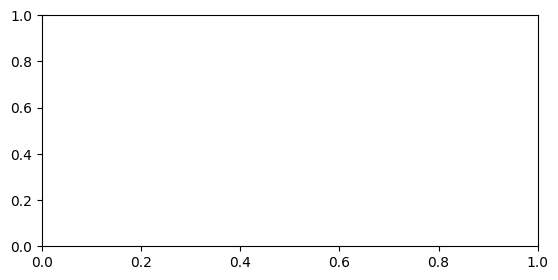

In [40]:
#  Bar Horizontal of Cities and Sum of Incomes, Ranked

#TODO: Add Rank and enable search for city, return 10 before, after
#TODO: replace wah with city_inc?
from matplotlib.pyplot import figure

label_format =  '{:,.0f} M'

rank_start = 10
rank_end = 20

fig, ax = plt.subplots()
#plt.figure().set_figheight(25)

# sort out fig height depending on how rows being returned
figh = int((rank_end - rank_start) / 3)
fig.set_figheight(figh)

#y_pos = np.arange(len(city_inc_df.iloc[rank_start:rank_end].index))

#y_pos = np.arange(len(city_inc_df.iloc[rank_start:rank_end].index))
y_pos =np.arange (rank_end - rank_start)


city_inc = city_inc_df.iloc[rank_start:rank_end].values / 1000000

ax.barh(y_pos, city_inc, align='center')
ax.set_yticks(y_pos, labels=city_inc_df.iloc[rank_start:rank_end].index)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)


ax.set_xlabel('Sum of NP Income')
ax.set_title(f'City by Income Rank {rank_start} to {rank_end}')

plt.show()



## Cities and Income Ranking

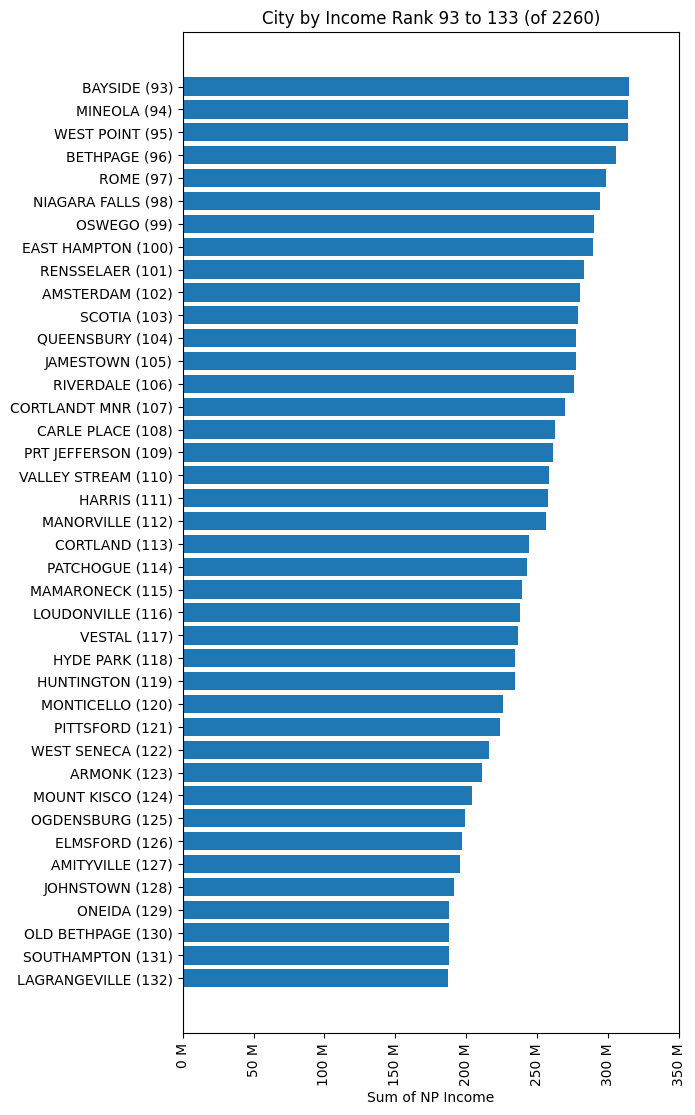

In [43]:
# ------------------------------------
# Cities and NP Income Ranking
# ------------------------------------

# Bar Horizontal of Cities and Sum of Incomes, Ranked
# Provide a City Name, Nbr of Results wanted
# or ranking range

# Notes:
#   Using cities_df dataframe
#   want to add other census data to a cities dataframe

#TODO:  Could a City List to pick a few comparison cities

# provide a city or give rank start/end
#

results_cnt = 40 # how many cities to get

srch_city = 'CORTLAND'
#srch_city = 'NEW YORK'
# Find Rank of Cortland, then get 10 before and 10 after
rank_start = (cities_df[cities_df['CITY'] == srch_city]['INCOME_RANK'].values[0]) - (int(results_cnt/2))
rank_end = (cities_df[cities_df['CITY'] == srch_city]['INCOME_RANK'].values[0]) + (int(results_cnt/2))

if rank_start < 0:
    rank_start = 0
rank_end = rank_start + results_cnt

#rank_start = 10
#rank_end = 40

cities_cnt = len(cities_df.index)
label_format =  '{:,.0f} M'


fig, ax = plt.subplots()
#plt.figure().set_figheight(25)

# sort out fig height depending on how rows being returned
figh = int( ( (rank_end - rank_start) / 3))
fig.set_figheight(figh)

#y_pos = np.arange(len(city_inc_df.iloc[rank_start:rank_end].index))

y_pos =np.arange (rank_end - rank_start)

# city_inc = city_inc_df.iloc[rank_start:rank_end].values / 1000000
city_inc = cities_df['INCOME_AMT'].iloc[rank_start:rank_end].values/1000000

city_labs = cities_df['CITY'].iloc[rank_start:rank_end].values + ' ' + \
            "(" + cities_df['INCOME_RANK'].iloc[rank_start:rank_end].astype(str) + ")"

ax.barh(y_pos, city_inc, align='center')

#ax.set_yticks(y_pos, labels=city_inc_df.iloc[rank_start:rank_end].index)
ax.set_yticks(y_pos, labels=city_labs)


ax.invert_yaxis()  # lowest rank (greater income) at top

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)

ax.set_xlabel('Sum of NP Income')
ax.set_title(f'City by Income Rank {rank_start} to {rank_end} (of {cities_cnt})')

plt.show()




In [ ]:
#display(cities_df)
#cities_df[['CITY', 'INCOME_RANK', 'INCOME_AMT']]

rank_start = 10
rank_end = 20

#cities_df.info()

print ("Len df: ", len(cities_df.index))

print ("shape 0 df: ",cities_df.shape[0] )

print (cities_df.shape)

print ("city size: ", cities_df['CITY'].size )


#cities_cnt = cities_df.size

#cities_df['CITY'].iloc[rank_start:rank_end].values

#cities_df['INCOME_RANK'].iloc[rank_start:rank_end].values

#cities_df['INCOME_AMT'].iloc[rank_start:rank_end].values


Len df:  2260
shape 0 df:  2260
(2260, 3)
city size:  2260


In [ ]:
cities_df['INCOME_RANK']

,INCOME_RANK
0,0
1,1
2,2
3,3
4,4
...,...
2255,2255
2256,2256
2257,2257
2258,2258


In [ ]:
type(cities_ser)

pandas.core.series.Series

## Income and NTEE

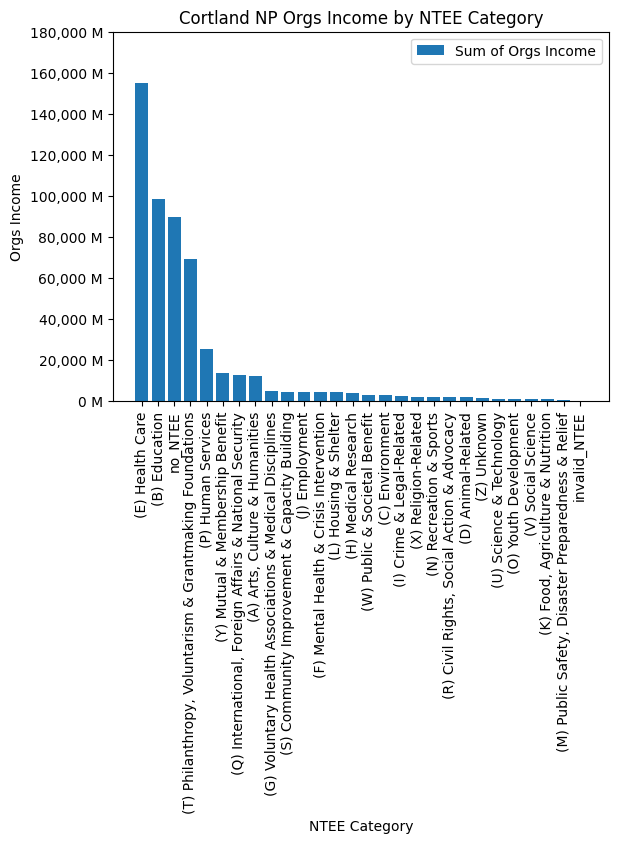

In [39]:
# ----- INCOME BY NTEE category

result = df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

label_format =  '{:,.0f} M'

fig, ax1 = plt.subplots()
#fig, (ax1, ax2)  = plt.subplots(2, 1)

ax1.bar(result.index,
        #result.values,
        result.values / 1000000,
        #color='#FF0000',
        label='Sum of Orgs Income')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(result.index)
ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])


ax1.set_xlabel('NTEE Category')
ax1.set_ylabel('Orgs Income')
ax1.set_title('Cortland NP Orgs Income by NTEE Category')

plt.show()


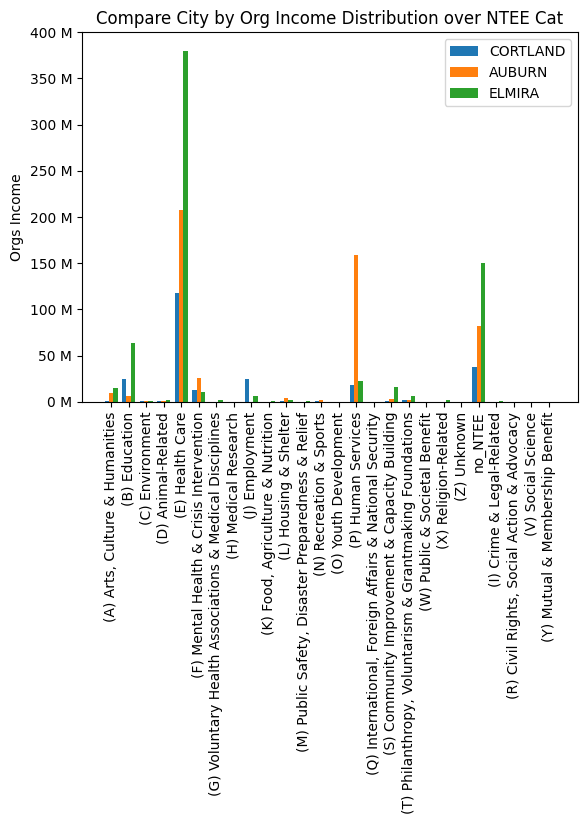

In [ ]:
# V2: Compare Orgs Income Sum over NTEEs of different Cities
# merge into one dataframe
# do grouped bar

#TODO:  Add Census Population
#TODO:  Add Cities List, iterate dataframe
#TODO:  Each NTEE as Percentage of Total to "normalize"
#TODO:  research concat vs join/merge.  docs say concatcreate copies.
#TODO:  research multi-index
#TODO:  skip certain codes, especially like Health Care

# NOTE: comparing all NY to cortland disappears cortland

cortland_ntee = df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
#display(cortland_ntee)
cortland_ntee=cortland_ntee.rename(columns = {'sum':'CORTLAND'})

# compare to different places

comp_city = 'AUBURN'
comp_ntee = df[df['CITY'] == comp_city].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
comp_ntee=comp_ntee.rename(columns = {'sum': comp_city})

comp2_city = 'ELMIRA'
comp2_ntee = df[df['CITY'] == comp2_city].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
comp2_ntee=comp2_ntee.rename(columns = {'sum': comp2_city})

# Combine the results into a single DataFrame - gives multi-index
# it's handy for iteration, but should research
#result = pd.concat([cortland_ntee, comp_ntee], keys=['ntee_cat', 'ntee_cat'], axis=1)
result = pd.concat([cortland_ntee, comp_ntee, comp2_ntee],
                   keys=['ntee_cat', 'ntee_cat', 'ntee_cat'],
                   axis=1)


# display(result)
# print (result.columns)
# print (result.info())
# print (result.describe())

# can access values with multi index
# result['ntee_cat', 'cortland_sum'].plot.bar(legend=True)

fig, ax = plt.subplots()
width = 0.25  # the width of the bars
multiplier = 0

x = np.arange(len(result['ntee_cat']))

for attribute, measurement in result['ntee_cat'].items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    # print ("Multiplier: ", multiplier)
    # print ("offset: ", offset)
    # print ("attribute: ", attribute)
    # print ("measurement: ", measurement)

label_format = '{:,.0f} M'

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Orgs Income')
ax.set_title('Compare City by Org Income Distribution over NTEE Cat')

#ax.set_xticks(x + width, result['ntee_cat'])
ax.set_xticks(x + width, result.index)
ax.legend(loc='upper right') #, ncols=3)

# avoid weird warning, formatter/locator order
#ax.xaxis.set_ticks(result['ntee_cat'])
#ax.xaxis.set_ticklabels(result['ntee_cat'],rotation=90)
ax.xaxis.set_ticklabels(result.index, rotation=90)

# this odd line remove warning to use formatter before locator
ax.set_yticks(ax.get_yticks())
ticks_loc = ax.get_yticks().tolist()
ax.set_yticklabels([label_format.format(x/1000000) for x in ticks_loc])

plt.show()




<Axes: xlabel='ntee_cat'>

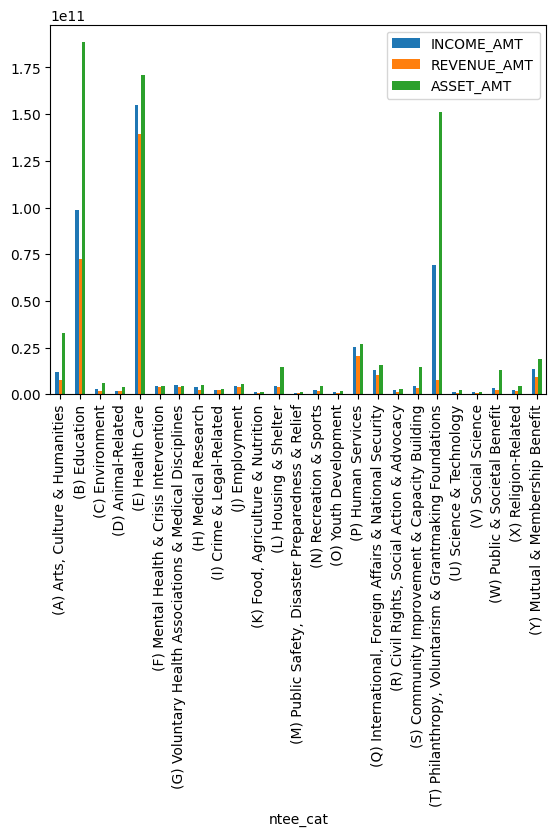

In [ ]:
# Using Pandas Plot with Filter
#

filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

#df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().plot.bar(legend=True)

df.loc[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot.bar(legend=True)

#df.loc[filt].groupby(['ntee_cat'])['REVENUE_AMT'].sum().plot.bar(legend=True)



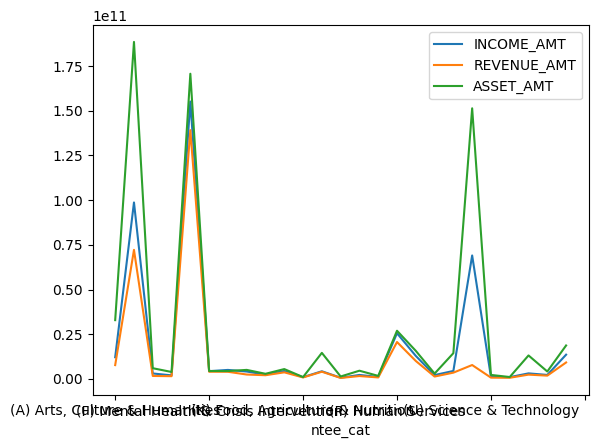

In [ ]:
# drafting Using Pandas Plot with Filter
# but plugging in ax

filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

#df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().plot.bar(legend=True)
#df.loc[filt].groupby(['ntee_cat'])['REVENUE_AMT'].sum().plot.bar(legend=True)

#df.loc[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot.bar(legend=True)



# ax = df.plot()
ax = df.loc[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot()

# ax.set_xticks(df.loc[filt].index)

#ax.set_xticklabels(df.C, rotation=90)




## Quick Plot Tests

In [ ]:
# testing summaries
# summarizing corland vs total

df.loc[df['CITY'] == 'CORTLAND', 'ntee_cat'].sum()

#Using loc:
#df.loc[df['CITY'] == 'CORTLAND'].INCOME_AMT.sum()

#Using groupby:
#df.groupby('CITY')['INCOME_AMT'].sum()

# Calculate sum of INCOME_AMT for CITY equals CORTLAND
cortland_income_sum = df[df['CITY'] == 'CORTLAND']['INCOME_AMT'].sum()

# Calculate total sum of INCOME_AMT for the entire DataFrame
total_income_sum = df['INCOME_AMT'].sum()

print("Sum of INCOME_AMT for CORTLAND:", cortland_income_sum)
print("Total sum of INCOME_AMT:", total_income_sum)



Sum of INCOME_AMT for CORTLAND: 244586221.0
Total sum of INCOME_AMT: 526874950693.0


<Axes: xlabel='ntee_cat'>

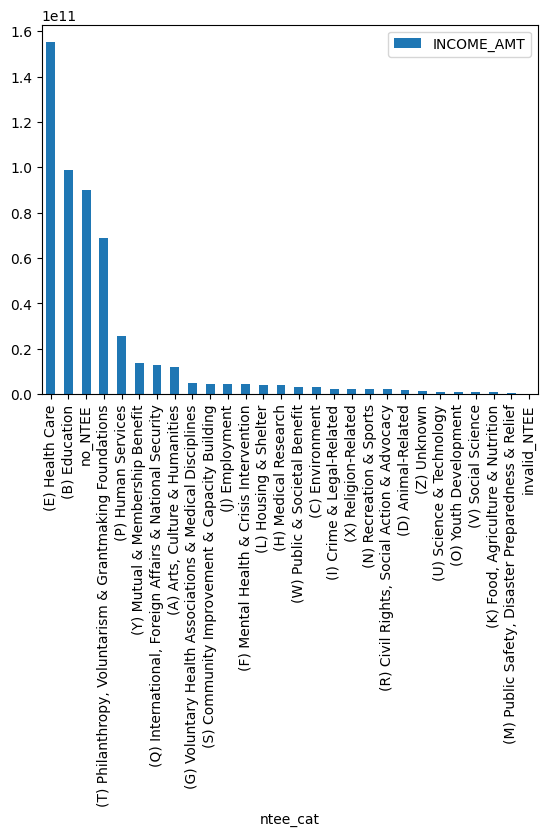

In [ ]:
# ----- INCOME BY ntee category
# simple pandas plot

# works
#df.groupby(['ntee_cat'])['INCOME_AMT'].sum().plot.bar(legend=True)

df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False).plot.bar(
    legend=True)



[]

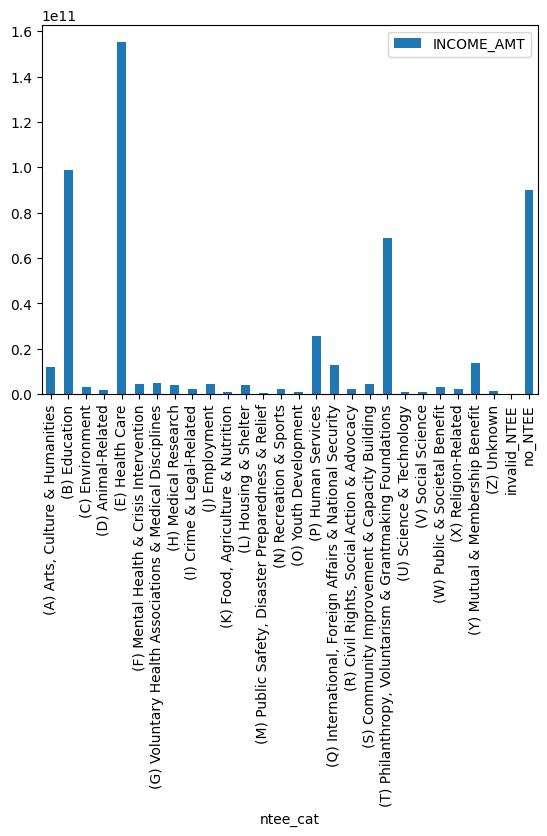

In [ ]:
# ----- Org Count BY ntee category

df.groupby(['ntee_cat'])['INCOME_AMT'].sum().plot.bar(legend=True).plot(legend=True,
             xlabel="NTEE CAT",
             ylabel="Nbr of Orgs",
             title="Orgs by NTEE CAT",
             table=True)


[]

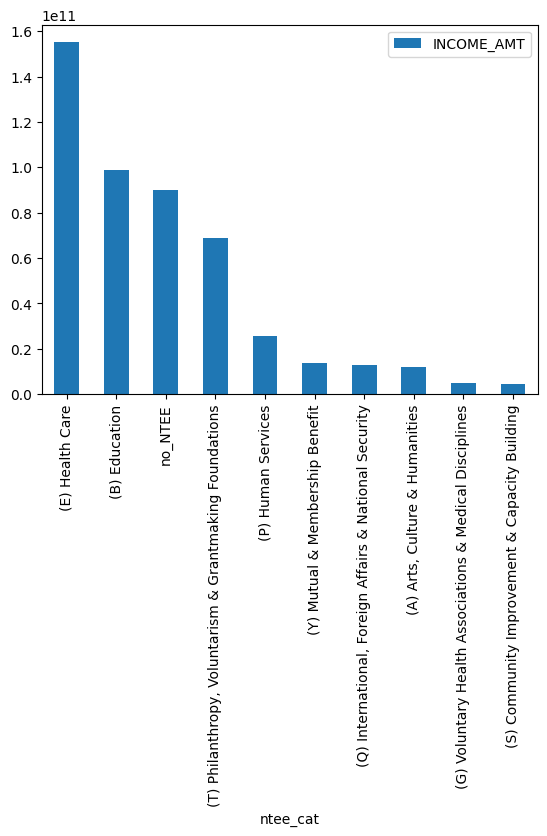

In [ ]:

df.groupby(['ntee_cat'])['INCOME_AMT'].sum('INCOME_AMT').sort_values().nlargest(10).plot.bar(legend=True).plot(legend=True,
                      title="Orgs by NTEE CAT",                                                                                                               xlabel="NTEE CAT",
                      ylabel="Nbr of Orgs",
                      table=True)



[]

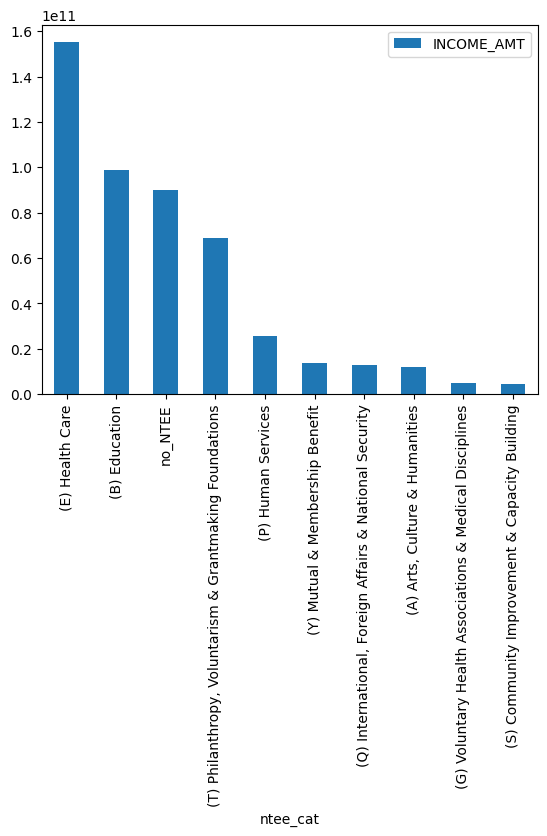

In [ ]:
df.groupby(['ntee_cat'])['INCOME_AMT'].sum('INCOME_AMT').sort_values().nlargest(10).plot.bar(legend=True).plot(legend=True,
                      xlabel="NTEE CAT",
                      ylabel="Nbr of Orgs",
                      title="Orgs by NTEE CAT",
                      table=True)



<Axes: title={'center': 'Count Orgs by NTEE Category'}, xlabel='NTEE Category', ylabel='Nbr of Orgs'>

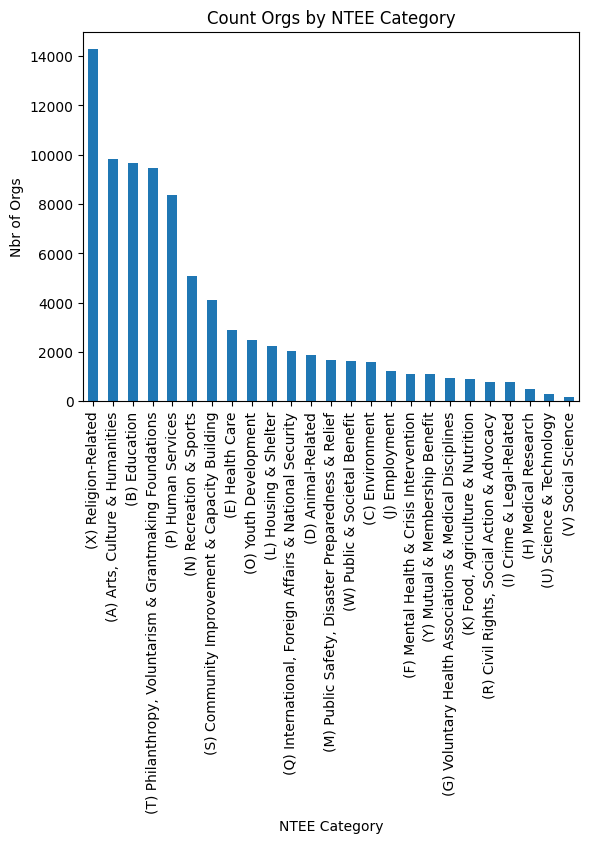

In [ ]:
# ----- Org Count BY ntee category


# df.groupby([['ntee_cat'], ['p_org_id']]).count().plot.bar(legend=True)
# df['ntee_cat'].groupby(['ntee_cat'], ['p_org_id']).count()
# df = data.groupby(['pulse', 'diet']).count()['p_org_id']
# df.groupby(['ntee_cat']).count()['p_org_id']
# df.groupby(['ntee_cat']).count()

# seems to work
#display (df.groupby(['ntee_cat'])['INCOME_AMT'].sum())

# display (df.groupby(['ntee_cat'])['p_org_id'].count())

# exclude = ['no_NTEE']

filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().sort_values(ascending=False).plot.bar(legend=False,
                      title="Count Orgs by NTEE Category",
                      xlabel = "NTEE Category",
                      ylabel = "Nbr of Orgs")





Text(0, 0.5, 'Nbr of Orgs')

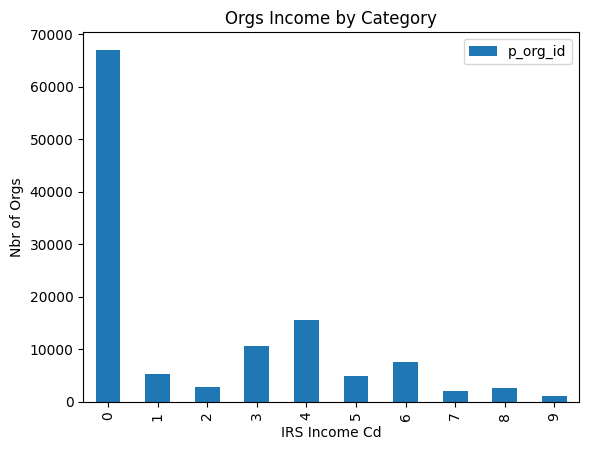

In [ ]:


filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

#df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().plot.bar(legend=True)

# df.loc[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot.bar(legend=True)

#df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(legend=True)

ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot(legend="Orgs",
              title='Orgs Income by Category',
              kind='bar')
ax.set_xlabel("IRS Income Cd")
ax.set_ylabel("Nbr of Orgs")




## Orgs by Income, binning

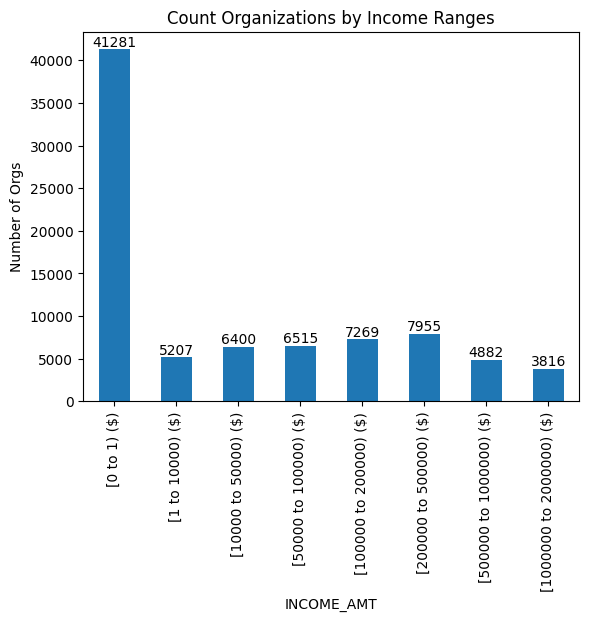

In [ ]:
# ---------------------------
# Plot Income with user-defined bins
# ---------------------------
from matplotlib import pyplot as plt
import locale
import re

# TODO: format bins tidier.  have to break apart binning to apply format?
# label_format = {:,.0f}

bins = [0, 1,10000,50000,100000,200000, 500000,1000000, 2000000]

out = pd.cut(df['INCOME_AMT'], bins=bins, right=False, include_lowest=True)
#print (type(out), out.count())
#print (out.value_counts(sort=False))

# out.value_counts().reindex(out.cat.categories)

# collect labels for x axis
# print ("\nout cat: ", type(out.cat))
# print ("out cat categories: ", type(out.cat.categories))


xlabs = []
for c in out.cat.categories:
  # print (type(c), c)
  h = str(c)
  #i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  i = h.replace(","," to")
  xlabs.append(i + " ($)")


#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
ax = out.value_counts(sort=False).plot.bar()

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by Income Ranges")
ax.bar_label(ax.containers[0])
plt.show()




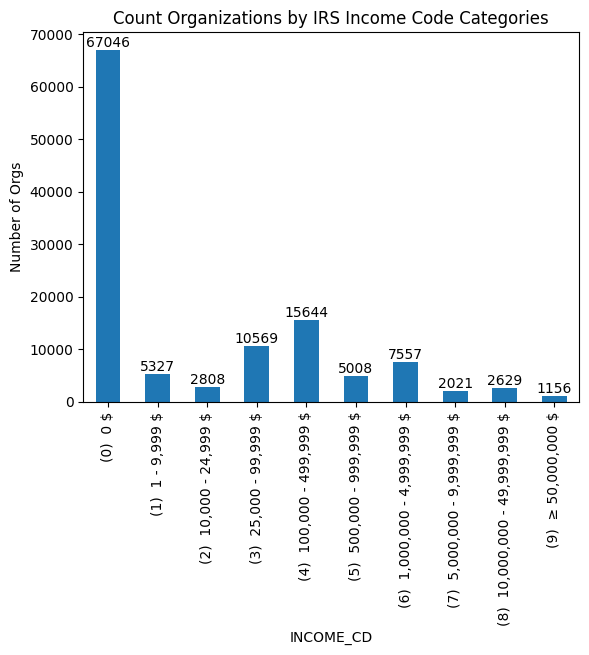

In [ ]:
# ---------------------------------------------
# Using IRS Income Code, Count Orgs by Income
# Lookup Income Code
# --------------------------------------------

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['INCOME_CD'] if c != 'define') :
  # print (c, ":", bmf['INCOME_CD'][c] )
  xlabs.append(f"({c})  {bmf['INCOME_CD'][c]} $")

ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Income Code Categories")
ax.bar_label(ax.containers[0])
plt.show()



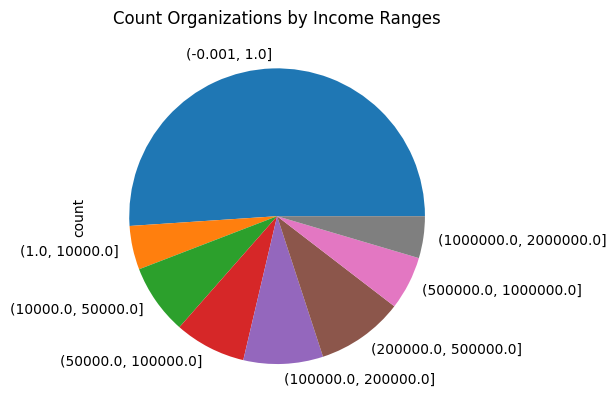

In [ ]:
# can i make a pie chart from same org count / income

# Plot income in bins

bins = [0,1,10000,50000,100000,200000, 500000,1000000, 2000000]

out = pd.cut(df['INCOME_AMT'], bins=bins, include_lowest=True)
#out.count()
#out.value_counts(sort=False)

# works -- but why is there a bracket in there?
out.value_counts().reindex(out.cat.categories)

# collect labels for x axis
import re
xlabels = []
for c in out.cat.categories:
  h = str(c)
  i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  xlabels.append(i)

# xlabs = ["1", "2", "3","4", "5", "6", "7", "8"]

#df[df.columns[1:]].sum().plot.pie()

ax = out.value_counts(sort=False).plot.pie()
# ax.set_xticklabels(xlabs)
ax.set_xticklabels(ax.get_xticklabels())

# ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by Income Ranges")
# ax.bar_label(ax.containers[0])
plt.show()



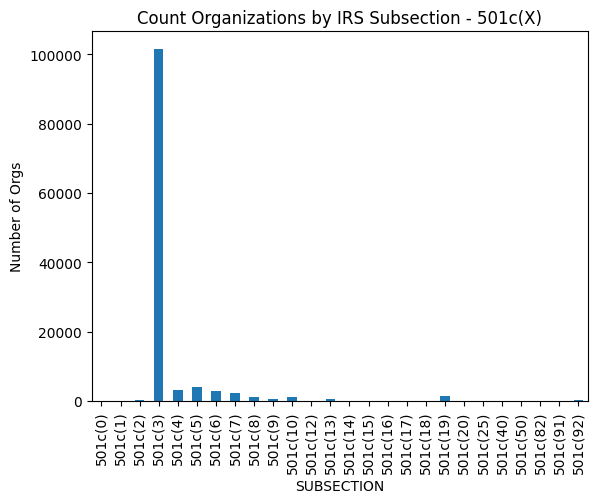


List of IRS Subsections
501c(define): Subsection Codes are the codes shown under section 501(c) of the Internal Revenue Code of 1986 which define the category under which an organization may be exempt. A table of subsection and classification codes can be found on page 6. From one to three subsection codes may be selected per request. If classification code is also selected only one subsection code may be selected.
501c(1): Corporations Organized Under Act of Congress (including Federal Credit Unions
501c(2): Title Holding Corporations for Exempt Organization
501c(3): Charitable Organization
501c(4): Civic Leagues and Social Welfare Organizations and Local Associations of Employees
501c(5): Labor, Agricultural and Horticultural Organizations
501c(6): Business Leagues, etc.
501c(7): Social and Recreation Clubs
501c(8): Fraternal Beneficiary Societies
501c(9): Voluntary Employees' Beneficiary Associations
501c(10): Domestic Fraternal Societies
501c(11): Teachers' Retirement Fund Associa

In [ ]:
# this one would be better with just 501c(x) in x
# table of lookups below

# --------------------------------
# Count Orgs By Subsection-- 501cX
# look up Subsection Code
# -------------------------------

#TODO:  why don't 90s show up in list after plot?
#TODO: compare cities



from matplotlib import pyplot as plt
import locale
import re

xlabs = []

result = df.groupby(['SUBSECTION'])['p_org_id'].count()
# xlabs = result.index
for x in result.index:
  xlabs.append(f"501c({x})")

#for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  # print (c, ":", bmf['SUBSECTION'][c] )
  # xlabs.append(f"({c})  {bmf['SUBSECTION'][c]} ")

#ax = df.groupby(['SUBSECTION'])['p_org_id'].count().plot.bar(rot=0)
ax = result.plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Subsection - 501c(X)")
#ax.bar_label(ax.containers[0])
plt.show()

print ("\nList of IRS Subsections")

#for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
for c in  bmf['SUBSECTION']:
  print (f"501c({c}): {bmf['SUBSECTION'][c]}" )
  # xlabs.append(f"501c({c}):  {bmf['SUBSECTION'][c]} ")






## Orgs, Subsection, Org Type

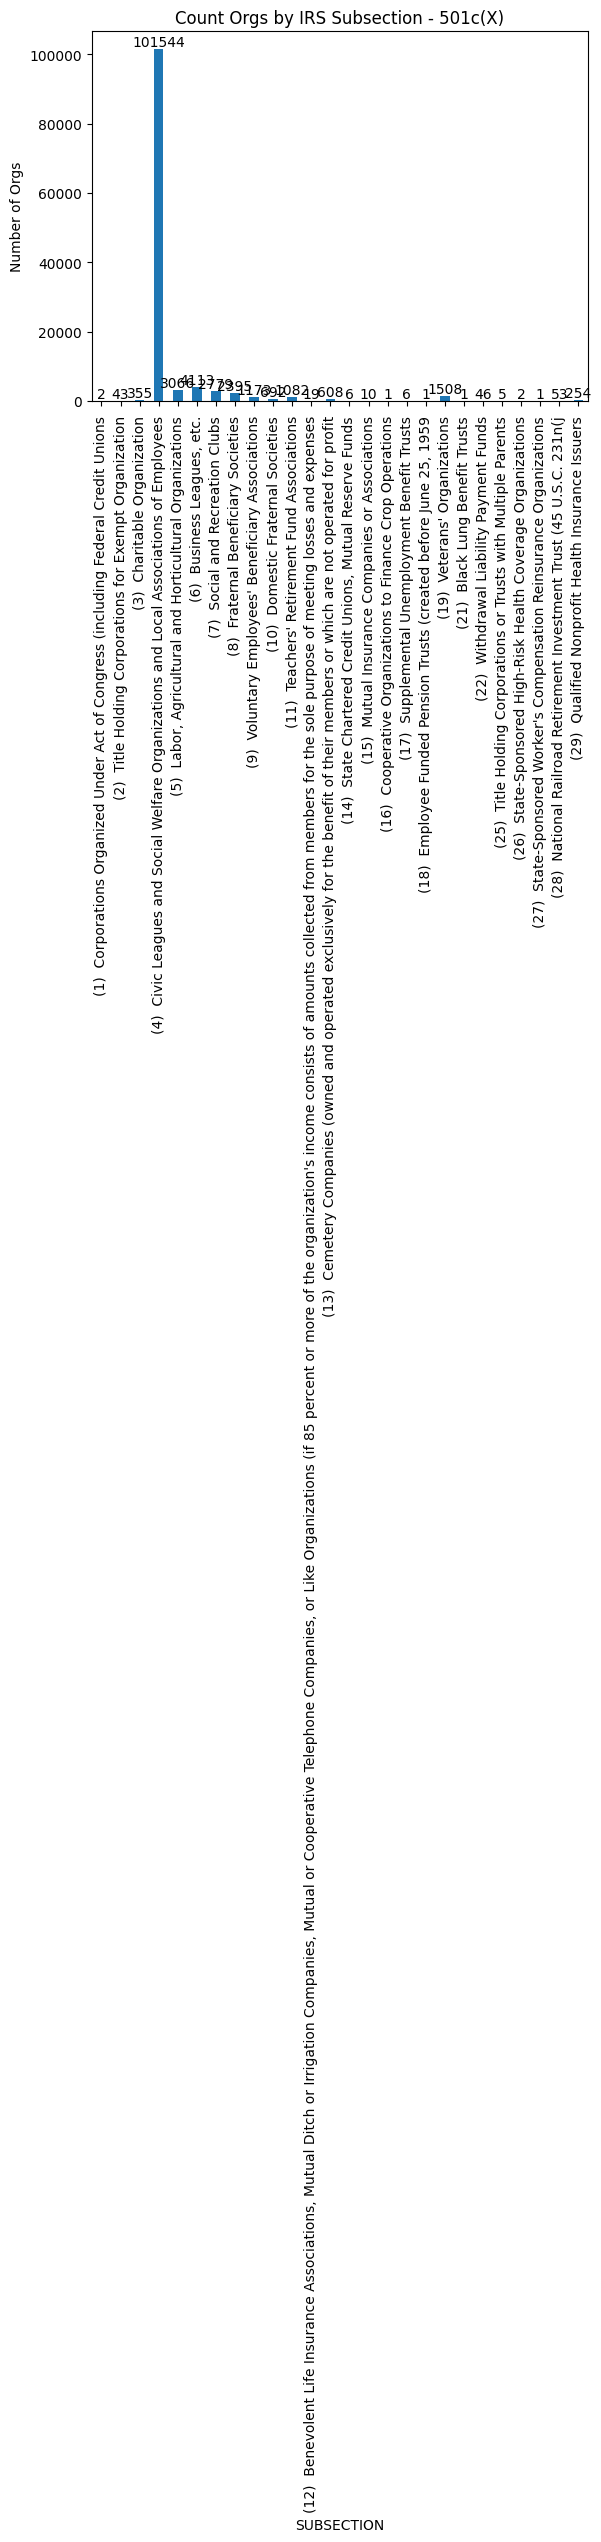

In [ ]:
# --------------------------------
# Count Orgs By Subsection-- 501cX
# look up Subsection Code
# -------------------------------

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  # print (c, ":", bmf['SUBSECTION'][c] )
  xlabs.append(f"({c})  {bmf['SUBSECTION'][c]} ")

ax = df.groupby(['SUBSECTION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Orgs by IRS Subsection - 501c(X)")
ax.bar_label(ax.containers[0])
plt.show()




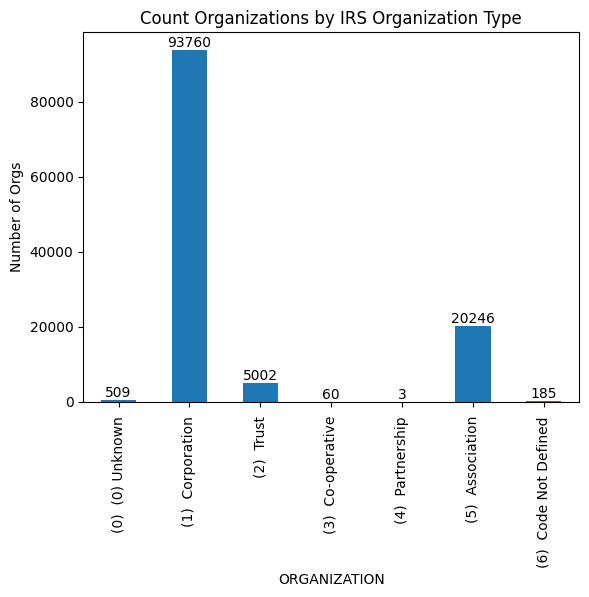

In [ ]:
# -------------------------
# count Orgs by ORGANIZATION Type
# lookup Organization Type Code
# ------------------------------

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  # print (c, ":", bmf['INCOME_CD'][c] )
  xlabs.append(f"({c})  {bmf['ORGANIZATION'][c]} ")

ax = df.groupby(['ORGANIZATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Organization Type")
ax.bar_label(ax.containers[0])
plt.show()



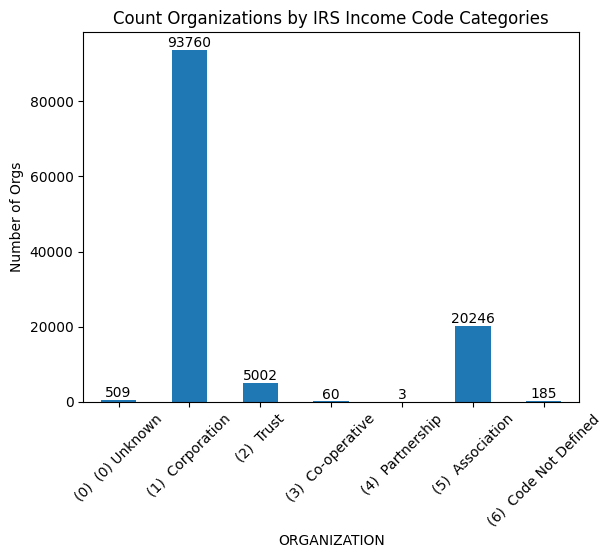

In [ ]:
# ok try this one for looking up ORGANIZATION code

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

# TODO: check small datasets when there is no data for some lookup
# can use results.index as standard approach

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  xlabs.append(f"({c})  {bmf['ORGANIZATION'][c]}")

ax = df.groupby(['ORGANIZATION'])['p_org_id'].count().plot.bar()

ax.set_xticklabels(xlabs,rotation=45)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Org Type Categories")
ax.bar_label(ax.containers[0])
plt.show()



## Ruling, Ruling Date

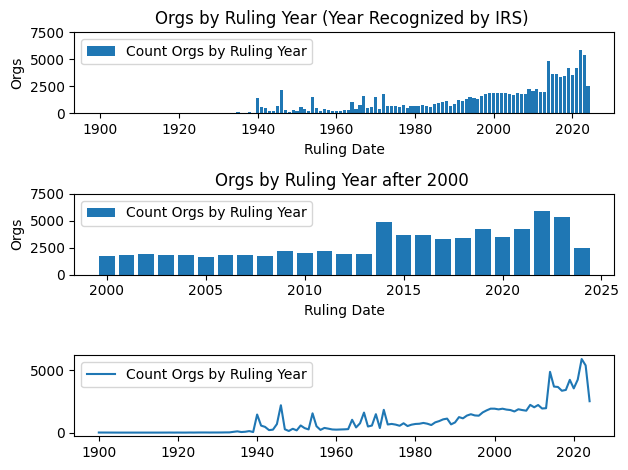

In [ ]:
# --- Plot RULING Dates

# result = df['RULING'].groupby(df['RULING']).count()

result = df.groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

# result = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

# label_format = '{:,.0f} M'

#fig, ax1 = plt.subplots()
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1)

ax3.plot(result.index,
        result.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax3.legend()


ax1.bar(result.index,
        result.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)
#ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
# ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel('Ruling Date')
ax1.set_ylabel('Orgs')
ax1.set_title('Orgs by Ruling Year (Year Recognized by IRS) ')

# --- ax2 ----

filt = (df.RULE_DT > '2000-01-01')
result2 = df[filt].groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

ax2.bar(result2.index,
        result2.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax2.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)
#ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax2.set_yticks(ax1.get_yticks())
ticks_loc = ax2.get_yticks().tolist()
# ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax2.set_xlabel('Ruling Date')
ax2.set_ylabel('Orgs')
ax2.set_title('Orgs by Ruling Year after 2000 ')

fig.tight_layout()
plt.show()



In [ ]:
# look at count orgs by ruling

#cortland_ntee = df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
# df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])


#df.groupby(df.your_date_column.dt.month)['values_column'].sum()

# df.groupby(df.RULE_DT.dt.month)['INCOME_AMT'].sum()
# df.groupby(df.RULE_DT.dt.year)['INCOME_AMT'].sum()
# df.groupby(df.RULE_DT.dt.year)['p_org_id'].count()

df.groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

# applying groupby
#df.groupby(pd.Grouper(key='RULE_DT', axis=0,
#                      freq='1Y', sort=True)).count()

# df.groupby(pd.Grouper(key='RULE_DT', axis=0,
#                      freq='1Y', sort=True)).count()

# df.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='M')).sum()




RULE_DT
1900.0       7
1905.0       1
1910.0       1
1913.0       1
1915.0       1
          ... 
2020.0    3534
2021.0    4229
2022.0    5878
2023.0    5369
2024.0    2509
Name: p_org_id, Length: 113, dtype: int64

## Affiliation Plot

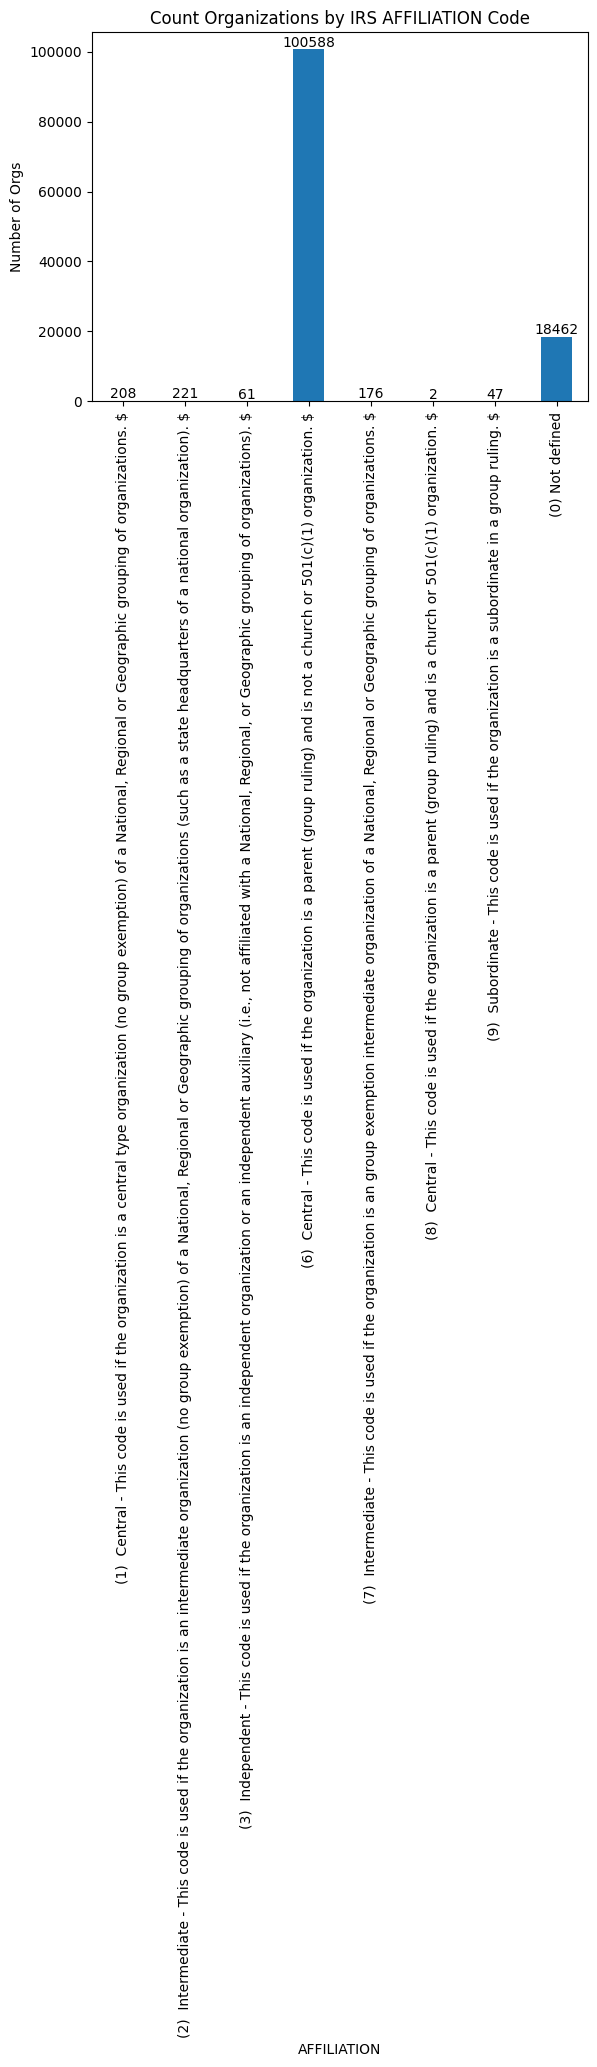

In [ ]:
# affiliation plot

xlabs = []

for c in (c for c in bmf['AFFILIATION'] if c != 'define') :
  #print (c, ":", bmf['AFFILIATION'][c] )
  xlabs.append(f"({c})  {bmf['AFFILIATION'][c]} $")

# TODO: add 0 to affiliation lookup
# TODO: add short descriptions for these plots
xlabs.append("(0) Not defined")

#ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax = df.groupby(['AFFILIATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS AFFILIATION Code")
ax.bar_label(ax.containers[0])
plt.show()




## Activity

In [ ]:
# ACT1-3 NOT Implemented

# df.groupby(['ACTIVITY'])['p_org_id'].count()
#df.groupby(['ACT1'])['p_org_id'].count()

for c in (c for c in bmf['ACTIVITY'] if c != 'define') :
  print (c, ":", bmf['AFFILIATION'][c] )
  #xlabs.append(f"({c})  {bmf['FOUNDATION'][c]}")



## Foundation

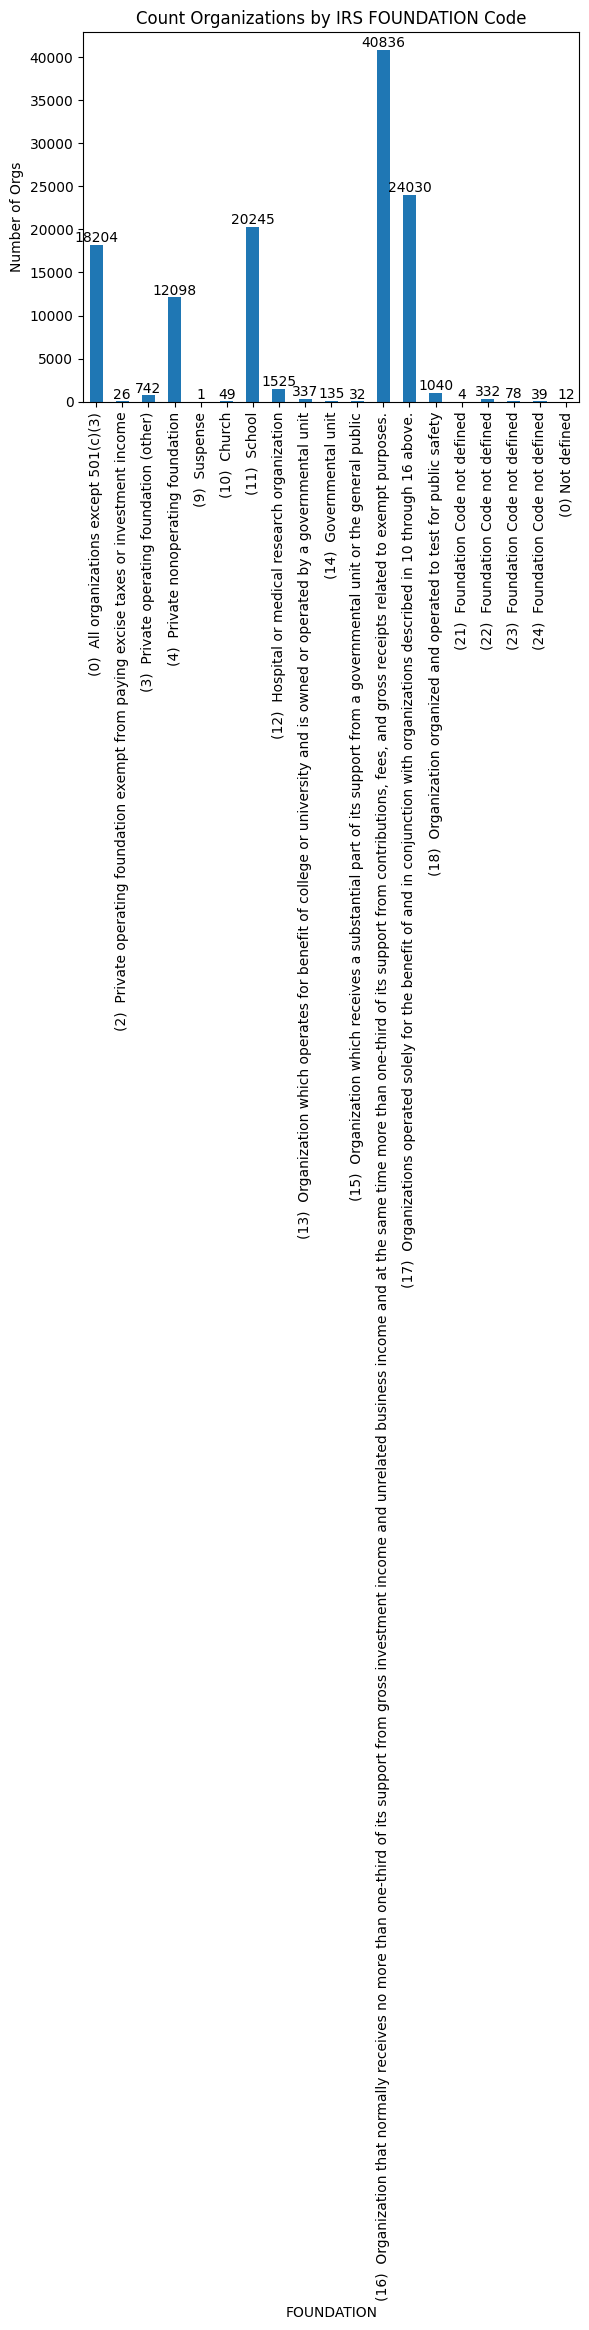

In [ ]:
# Foundation Plot

# print (df.groupby(['FOUNDATION'])['p_org_id'].count())

xlabs = []

for c in (c for c in bmf['FOUNDATION'] if c != 'define') :
  #print (c, ":", bmf['AFFILIATION'][c] )
  xlabs.append(f"({c})  {bmf['FOUNDATION'][c]}")

xlabs.append("(0) Not defined")

#ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax = df.groupby(['FOUNDATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS FOUNDATION Code")
ax.bar_label(ax.containers[0])
plt.show()




ConversionError: Failed to convert value(s) to axis units: Index(['(A) Arts, Culture & Humanities', '(B) Education', '(C) Environment',
       '(D) Animal-Related', '(E) Health Care',
       '(F) Mental Health & Crisis Intervention',
       '(G) Voluntary Health Associations & Medical Disciplines',
       '(H) Medical Research', '(I) Crime & Legal-Related', '(J) Employment',
       '(K) Food, Agriculture & Nutrition', '(L) Housing & Shelter',
       '(M) Public Safety, Disaster Preparedness & Relief',
       '(N) Recreation & Sports', '(O) Youth Development',
       '(P) Human Services',
       '(Q) International, Foreign Affairs & National Security',
       '(R) Civil Rights, Social Action & Advocacy',
       '(S) Community Improvement & Capacity Building',
       '(T) Philanthropy, Voluntarism & Grantmaking Foundations',
       '(U) Science & Technology', '(V) Social Science',
       '(W) Public & Societal Benefit', '(X) Religion-Related',
       '(Y) Mutual & Membership Benefit', '(Z) Unknown', 'invalid_NTEE',
       'no_NTEE'],
      dtype='object', name='ntee_cat')

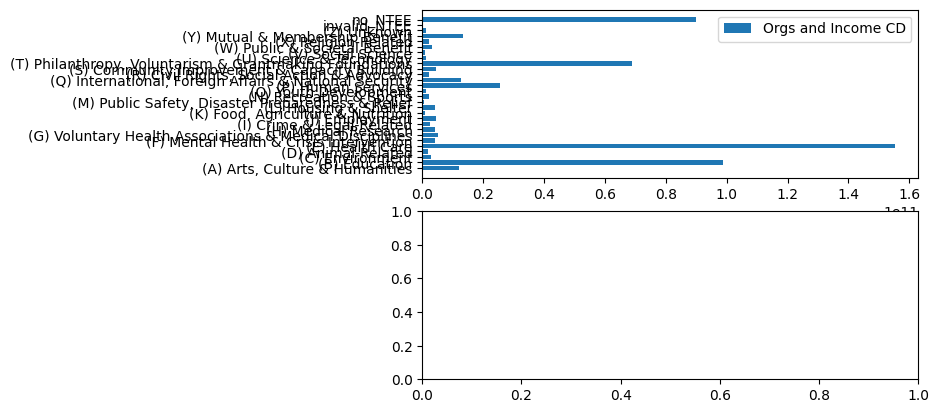

<Figure size 2000x40000 with 0 Axes>

In [ ]:
# ----- INCOME BY ntee category
# attempted comparison between NY and Cortland
# numbers oddly wrong and formatting problems


# import matplotlib.pyplot as plt
# import numpy as np

# standardize plotting

result = df.groupby(['ntee_cat'])['INCOME_AMT'].sum()

res_cortland = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum()

label_format = '{:,.0f}'

fig, (ax1, ax2) = plt.subplots(2,1 )

plt.figure(figsize=(20,400))

#fig, (ax1, ax2)  = plt.subplots(2, 1)

# ax1 = plt.subplot(111)

ax1.barh(result.index,
        result.values,
        #color='#FF0000',
        label='Orgs and Income CD')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(result.index)
ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel('NTEE Category')
ax1.set_ylabel('Org Income')
ax1.set_title('Org Income By NTEE Category')

# -- cortland

# trying to put one x axis
# ax2 = plt.subplot(212, sharex=ax1)

ax2.bar(result.index,
        result.values,
        #color='#FF0000',
        label='Orgs and Income CD')
ax2.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax2.xaxis.set_ticks(result.index)
ax2.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax2.set_yticks(ax2.get_yticks())
ticks_loc2 = ax2.get_yticks().tolist()
ax2.set_yticklabels([label_format.format(x) for x in ticks_loc2])


ax2.set_xlabel('NTEE Category')
ax2.set_ylabel('Org Income')
ax2.set_title('Org Income By NTEE Category')

plt.show()


ConversionError: Failed to convert value(s) to axis units: Index(['ACCORD', 'ACRA', 'ADAMS', 'ADAMS BASIN', 'ADAMS CENTER',
       'ADDISLEIGH PK', 'ADDISON', 'ADIRONDACK', 'AFTON', 'AIRMONT',
       ...
       'YORKTOWN', 'YORKTOWN HEIGHTS', 'YORKTOWN HGTS', 'YORKTOWN HTS',
       'YORKVILLE', 'YORTOWN HEIGHTS', 'YOUNGSTOWN', 'YOUNGSVILLE',
       'YRACUSE NY', 'YULAN'],
      dtype='object', name='CITY', length=2260)

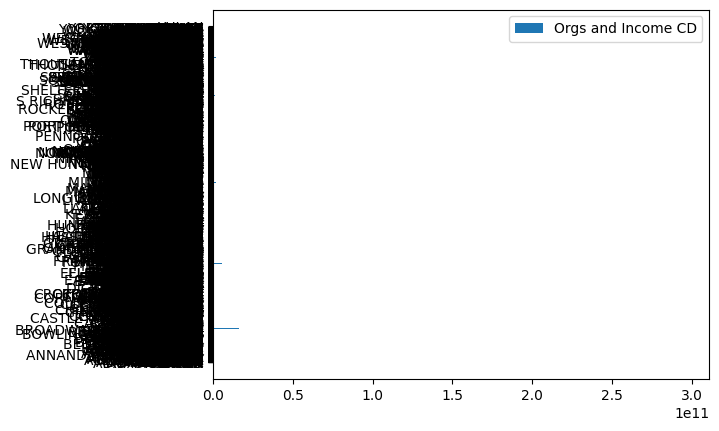

<Figure size 2000x40000 with 0 Axes>

In [ ]:
# Bar Horizontal

result = df.groupby(['CITY'])['INCOME_AMT'].sum()

# res_cortland = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum()

label_format = '{:,.0f}'

# fig, (ax1, ax2) = plt.subplots(2,1 )

fig, ax1  = plt.subplots(1 )

plt.figure(figsize=(20,400))

#fig, (ax1, ax2)  = plt.subplots(2, 1)

# ax1 = plt.subplot(111)

ax1.barh(result.index,
        result.values,
        #color='#FF0000',
        label='Orgs and Income CD')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(result.index)
ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel('NTEE Category')
ax1.set_ylabel('Org Income')
ax1.set_title('Org Income By NTEE Category')


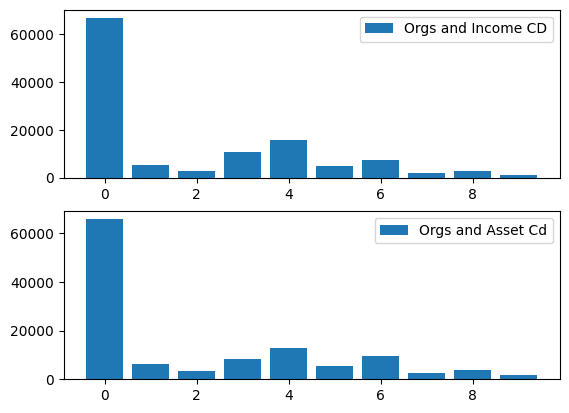

In [ ]:
# creating figure and defining ax
# feels more sensible and explicit


result = df.groupby(['INCOME_CD']).size()

fig, (ax1, ax2)  = plt.subplots(2, 1)

ax1.bar(result.index,
        result.values,
        #color='#FF0000',
        #linestyle='--',
        label='Orgs and Income CD')
ax1.legend()
ax1.set_ylabel = 'Orgs'
ax1.set_xlabel = 'Income Code'
ax1.set_title = 'Title'



result2 = df.groupby(['ASSET_CD']).size()
ax2.bar(result2.index,
         result2.values,
         #color='#FF0000',
         #linestyle='--',
        label='Orgs and Asset Cd')

ax2.legend()
ax2.set_ylabel = 'Orgs'
ax2.set_xlabel = 'Asset Code'
ax2.set_title = 'Orgs and Asset'


plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X       5 non-null      int64
 1   Y       5 non-null      int64
dtypes: int64(2)
memory usage: 208.0 bytes


# 6 ScratchPad

This is a learning exercise. Leaving Miscellaneous ideas and code stubs for reference.

<Axes: xlabel='CITY'>

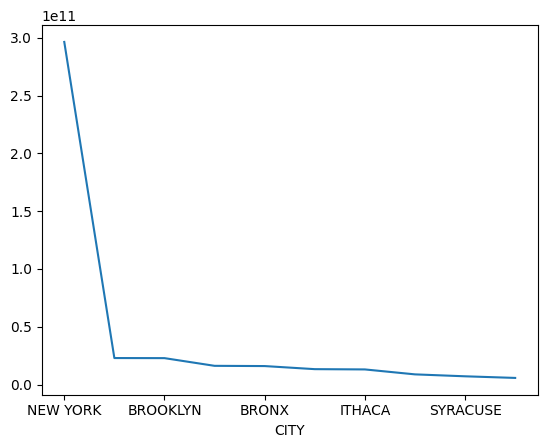

In [ ]:
# sum of income by city

df.groupby(['CITY'])['INCOME_AMT'].sum().nlargest(10)

#df.groupby(['CITY'])['INCOME_AMT'].sum().nlargest(10).plot()



In [ ]:
# ranking cities by income?
# ideally plotting rank ranges

#result =
#print (df.groupby(['CITY'])['INCOME_AMT'].sum().rank().sort_values())
#df.groupby("group_ID")["value"].rank(method="dense", ascending=False)

# df.groupby("CITY")["INCOME_AMT"].rank(method="dense", ascending=False)

# df.sort_values(by=['group_ID', 'value']).groupby('group_ID').cumcount(ascending=False) + 1

# df.groupby("CITY")["INCOME_AMT"].sum().sort_values(ascending=False) #.cumcount(ascending=False) + 1

#df['rank'] = df.sort_values(by=['group_ID', 'value']).groupby('group_ID').cumcount(ascending=False) + 1

#for method in ['average', 'min', 'max', 'dense', 'first']:
#    df[f'{method}_rank'] = df.groupby('group')['value'].rank(method)

#for method in ['average', 'min', 'max', 'dense', 'first']:
  # df[f'{method}_rank'] = df.groupby('CITY')['INCOME_AMT'].rank(method)
#  print (df.groupby('CITY')['INCOME_AMT'].rank(method))

#df.groupby('CITY')['INCOME_AMT'].sum().rank()

#city_inc_df = df.groupby("CITY")["INCOME_AMT"].sum().sort_values(ascending=False)

#g1 = df1.groupby(["Name", "City"], as_index=False).count()


# this looks to get cities by sum of income ordered by index
# the reset index creates both columns..
city_inc_df = df.groupby("CITY")["INCOME_AMT"].sum().sort_values(ascending=False).reset_index()

#city_inc_df["rank"] = city_inc_df.groupby("CITY")["INCOME_AMT"].rank(method="dense", ascending=False)
# display(city_inc_df)

#for method in ['average', 'min', 'max', 'dense', 'first']:
  # df[f'{method}_rank'] = df.groupby('CITY')['INCOME_AMT'].rank(method)





,CITY,INCOME_AMT
0,NEW YORK,2.963530e+11
1,WESTBURY,2.289168e+10
2,BROOKLYN,2.281771e+10
3,ROCHESTER,1.615927e+10
4,BRONX,1.595391e+10
...,...,...
2255,ROCKAWAY POINT,0.000000e+00
2256,ROCKVILLE,0.000000e+00
2257,ROCKVILLE CENTER,0.000000e+00
2258,LIMESTONE,0.000000e+00


<ipython-input-185-c7f7988f44bf>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.xaxis.set_ticklabels(wah['CITY'],rotation=90)


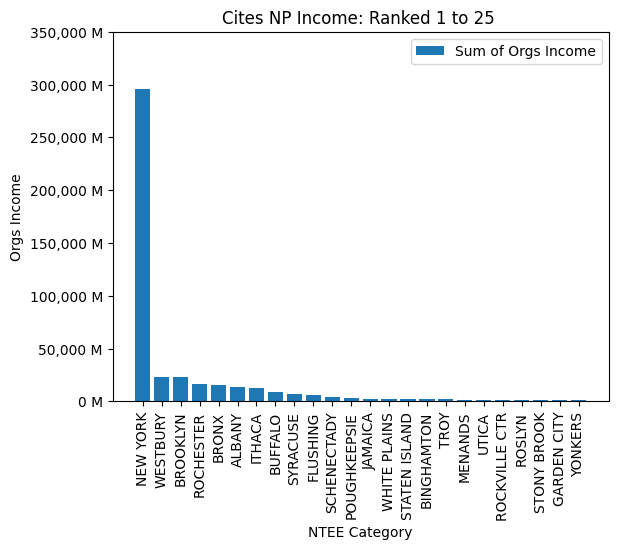

In [ ]:
# wah = city_inc_df.iloc[10:20]


filt = city_inc_df['CITY'].isin(['CORTLAND', 'AUBURN', 'ELMIRA', 'HOMER'])
city_inc_df[filt]

#wah = city_inc_df[filt]

# ok ranked citys

rank_start = 0
rank_end = 24

wah = city_inc_df.iloc[rank_start:rank_end]

#city_inc_df.iloc[10:20]

xlabs = wah['CITY']
#print (xlabs)
inc = wah['INCOME_AMT']
#print (inc)

label_format = '{:,.0f} M'

fig, ax1 = plt.subplots()
#fig, (ax1, ax2)  = plt.subplots(2, 1)

#TODO: horizontal bar, switch x and y
ax1.bar(#result.index,
        xlabs,
        #result.values,
        inc / 1000000,
        #color='#FF0000',
        label='Sum of Orgs Income')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)
#ax1.xaxis.set_ticklabels(result.index,rotation=90)

#ax1.xaxis.set_ticks(city_inc_df[filt].index)
ax1.xaxis.set_ticklabels(wah['CITY'],rotation=90)



# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])


ax1.set_xlabel('NTEE Category')
ax1.set_ylabel('Orgs Income')
ax1.set_title(f"Cites NP Income: Ranked {rank_start + 1} to {rank_end + 1} ")

plt.show()



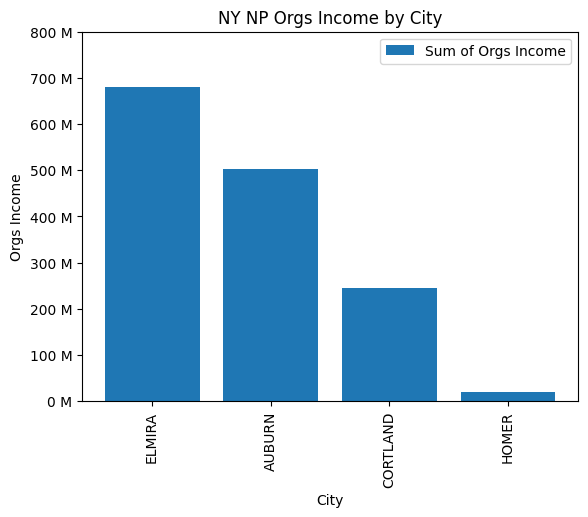

In [ ]:
# plotting selected cities and Income Sum
# result = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

filt = df['CITY'].isin(['CORTLAND', 'AUBURN', 'ELMIRA', 'HOMER'])

#result = df.groupby(['CITY'])['INCOME_AMT'].sum().nlargest(10)
result = df[filt].groupby(['CITY'])['INCOME_AMT'].sum().nlargest(10)

label_format = '{:,.0f} M'

fig, ax1 = plt.subplots()
#fig, (ax1, ax2)  = plt.subplots(2, 1)

ax1.bar(result.index,
        #result.values,
        result.values / 1000000,
        #color='#FF0000',
        label='Sum of Orgs Income')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(result.index)
ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])


ax1.set_xlabel('City')
ax1.set_ylabel('Orgs Income')
ax1.set_title('NY NP Orgs Income by City')

plt.show()


In [ ]:
filt = city_inc_df['CITY'].isin(['CORTLAND', 'AUBURN', 'ELMIRA', 'HOMER'])
city_inc_df[filt]

,CITY,INCOME_AMT
45,ELMIRA,679505019.0
58,AUBURN,502137881.0
113,CORTLAND,244586221.0
410,HOMER,20937313.0


In [ ]:
#
#city_inc_df.info()

#city_inc_df.index(start=1, stop=10)
#city_inc_df.item()

#city_inc_df.filter(items=[5,8], axis=0)
#print (type(city_inc_df))
#city_inc_df.info()

# city_inc_df.filter(items=range(10, 20), axis=0)
# result = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

result = city_inc_df.filter(items=range(10, 20), axis=0)

print (result.index[0], result.values[1][0])


<class 'pandas.core.frame.DataFrame'>
10 POUGHKEEPSIE


<ipython-input-215-1d745d1ff852>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.yaxis.set_ticklabels(yax)


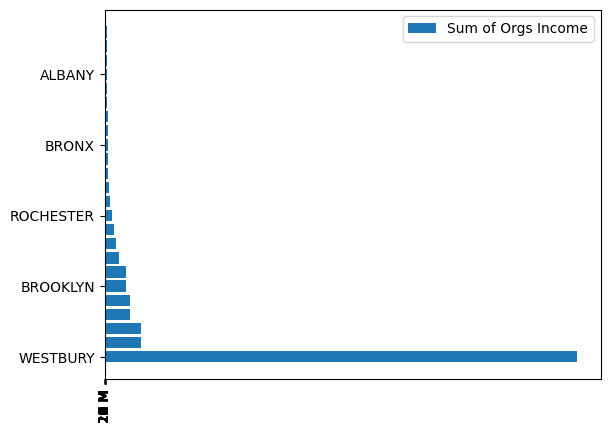

In [ ]:
# swap x y


# wah = city_inc_df.iloc[10:20]
#filt = city_inc_df['CITY'].isin(['CORTLAND', 'AUBURN', 'ELMIRA', 'HOMER'])
#city_inc_df[filt]

#wah = city_inc_df[filt]

# ok ranked cities

rank_start = 0
rank_end = 24

wah = city_inc_df.iloc[rank_start:rank_end]

yax = wah['CITY']
yax_pos = np.arange(len(yax))


#city_inc_df.iloc[10:20]
# xlabs = wah['CITY']
# inc = wah['INCOME_AMT']
xax = wah['INCOME_AMT']


#print (xax)
#print (yax)

label_format = '{:,.0f} M'

fig, ax1 = plt.subplots()
#fig, (ax1, ax2)  = plt.subplots(2, 1)

#TODO: horizontal bar, switch x and y
ax1.barh(yax_pos, #xax,
         wah['INCOME_AMT'], # yax,
        #wah['INCOME_AMT'],
        #color='#FF0000',
        label='Sum of Orgs Income')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)


#ax1.xaxis.set_ticks(wah.index)
#ax1.xaxis.set_ticklabels(wah.index,rotation=90)

ax1.xaxis.set_ticks(xax.index)
ax1.xaxis.set_ticklabels(xax,rotation=90)


#ax1.xaxis.set_ticks(city_inc_df[filt].index)
#ax1.yaxis.set_ticklabels(wah['CITY'])
ax1.yaxis.set_ticklabels(yax)

# this odd line remove warning to use formatter before locator
#ax1.set_xticks(ax1.get_xticks())
ticks_loc = ax1.get_xticks().tolist()
ax1.set_xticklabels([label_format.format(x) for x in ticks_loc])


#ax1.set_xlabel('NTEE Category')
#ax1.set_ylabel('Orgs Income')
#ax1.set_title(f"Cites NP Income: Ranked {rank_start + 1} to {rank_end + 1} ")

plt.show()






In [ ]:

df[['INCOME_AMT', 'REVENUE_AMT']].sum()

INCOME_AMT     5.268750e+11
REVENUE_AMT    3.597912e+11
dtype: float64

In [ ]:
# miscellanous lookups and tests

# just prints the column
# cortland_df['NTEE_CD']

# cortland_df['NTEE_CD', 'INCOME_AMT'].groupby(['NTEE_CD']).sum("INCOME_AMT")

# works
#df_tmp =  cortland_df.groupby(['NTEE_CD'])['INCOME_AMT'].describe()
#display(df_tmp)
#del df_tmp

# cortland_df.T.describe()

# key error
# cortland_df.T['INCOME_AMT'].describe()

# works
#cortland_df['INCOME_AMT'].describe()

# cortland_df['INCOME_AMT'].sum()

# cortland_df.groupby(['NTEE_CD'])['INCOME_AMT'].sum()

# works
# cortland_df.agg({'INCOME_AMT' : ['sum', 'min', 'max', 'mean', 'std']})

# df.groupby(['team', 'position'])['points', 'rebounds'].sum().reset_index()
# cortland_df.groupby(['NTEE_CODE'])['INCOME_AMT'].sum().reset_index()

#cortland_df.agg({'INCOME_AMT' : ['sum', 'min']}, axis="columns")

#np.std(cortland_df['INCOME_AMT'])

# np.median(cortland_df['INCOME_AMT'])
# np.average(cortland_df['INCOME_AMT'])



In [ ]:
# putting income into bins

bins = [0,1,10000,50000,100000,200000, 500000,1000000, 2000000]

# works, but seems to leave off nulls(?). labels clearly by bin
#cortland_df['NAME'].groupby(pd.cut(cortland_df['INCOME_AMT'], bins)).count()

# works: (-0.001, 1.0]
cortland_df['INCOME_AMT'].value_counts(bins=bins, sort=False)


(-0.001, 1.0]             64
(1.0, 10000.0]             1
(10000.0, 50000.0]         7
(50000.0, 100000.0]       10
(100000.0, 200000.0]      13
(200000.0, 500000.0]      12
(500000.0, 1000000.0]     16
(1000000.0, 2000000.0]     5
Name: count, dtype: int64

In [ ]:

# cortland_df.groupby(['NTEE_CD'])['INCOME_AMT'].describe()[['count', 'mean']]  # no error

# cortland_df.groupby(['CITY'])['INCOME_AMT'].describe()[['count', 'mean']]  # no error


# not fiddled
# df.describe(percentiles=[.10, .20, .30, .40, .50, .60, .70, .80, .90]))



,count,mean
CITY,,
CORTLAND,136.0,1.798428e+06


<Axes: >

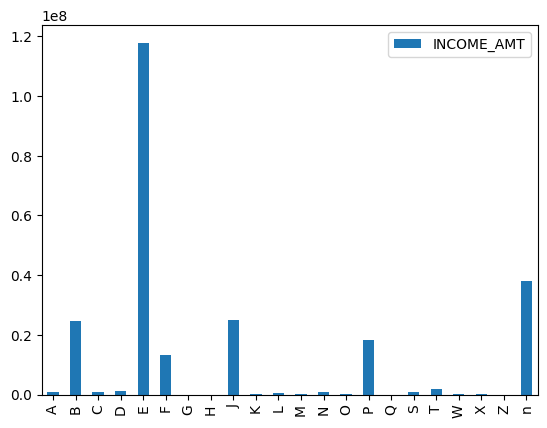

In [ ]:
# cortland_df.groupby(['NTEE_CD'][0])['EIN'].agg('count') # gives a df that counts values
#df.groupby('a').apply(lambda x: x['b'].sum()/x['c'].sum()) # stack exchange

# cortland_df.groupby(['NTEE_CD']).apply(lambda x: x['INCOME_AMT'].sum())

# se
# even_odd = ['even' if i%2==0 else 'odd' for i in df['A']]
# df.groupby(even_odd)['B'].mean()

#cortland_df.info()

# ntee_cat = [  "yes" if i else 'nan' for i in cortland_df['NTEE_CD']]
# cortland_df['ntee_cat'].value_counts()

# --- works ---
# ntee_cat = [  str(i)[0] if i else 'nan' for i in cortland_df['NTEE_CD']]
# cortland_df.groupby(ntee_cat)['INCOME_AMT'].sum().reset_index()

# --- fiddle ---
ntee_cat = [  str(i)[0] if i else 'nan' for i in cortland_df['NTEE_CD']]
#cortland_df.groupby(ntee_cat)['INCOME_AMT'].sum()
tmp = cortland_df.groupby(ntee_cat)['INCOME_AMT'].sum()

#tmp.plot(legend=True)
tmp.plot.bar(legend=True)


In [ ]:
# --- get census data for cities ---
# Not done, saving as fodder for later

import requests
import ast

from google.colab import userdata
ckey = userdata.get('census_api_key')

#https://stackoverflow.com/questions/28933220/us-census-api-get-the-population-of-every-city-in-a-state-using-python

#base_url = 'http://api.census.gov/data/%s/%s?key=%s&get=' % (str(year), dataset, self.key)

url = f'http://api.census.gov/data/2020/sf1?key={ckey}&get=P0010001&in=state:36'

print (url)


'''
county = c.get(['P0010001'], ['in=state:25', 'for=county:*'])
# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=county:*

city = c.get(['P0010001'], ['in=state:25', 'for=place:*'])
# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=place:*


def get_stuff(fields, geo, year=2010, dataset='sf1'):
    fields = [','.join(fields)]
    base_url = 'http://api.census.gov/data/%s/%s?key=%s&get=' % (str(year), dataset, self.key)
    query = fields
    for item in geo:
        query.append(item)
    add_url = '&'.join(query)
    url = base_url + add_url
    print(url)
    req = urllib.request.Request(url)
    response = urllib.request.urlopen(req)
    return response.read()

c = Census('<mykey>')
state = c.get(['P0010001'], ['for=state:25'])
# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&for=state:25
county = c.get(['P0010001'], ['in=state:25', 'for=county:*'])
# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=county:*
city = c.get(['P0010001'], ['in=state:25', 'for=place:*'])
# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=place:*

# Cast result to list type
state_result = ast.literal_eval(state.decode('utf8'))
county_result = ast.literal_eval(county.decode('utf8'))
city_result = ast.literal_eval(city.decode('utf8'))

def count_pop_county():
    count = 0
    for item in county_result[1:]:
        count += int(item[0])
    return count

def count_pop_city():
    count = 0
    for item in city_result[1:]:
        count += int(item[0])
    return count

'''





http://api.census.gov/data/2020/sf1?key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3&get=P0010001&in=state:36


"\ncounty = c.get(['P0010001'], ['in=state:25', 'for=county:*'])\n# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=county:*\n\ncity = c.get(['P0010001'], ['in=state:25', 'for=place:*'])\n# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&in=state:25&for=place:*\n\n\ndef get_stuff(fields, geo, year=2010, dataset='sf1'):\n    fields = [','.join(fields)]\n    base_url = 'http://api.census.gov/data/%s/%s?key=%s&get=' % (str(year), dataset, self.key)\n    query = fields\n    for item in geo:\n        query.append(item)\n    add_url = '&'.join(query)\n    url = base_url + add_url\n    print(url)\n    req = urllib.request.Request(url)\n    response = urllib.request.urlopen(req)\n    return response.read()\n\nc = Census('<mykey>')\nstate = c.get(['P0010001'], ['for=state:25'])\n# url: http://api.census.gov/data/2010/sf1?key=<mykey>&get=P0010001&for=state:25\ncounty = c.get(['P0010001'], ['in=state:25', 'for=county:*'])\n# url: http://api.cens

In [ ]:
# i think this might turn into text which can't be summed
df['INCOME_AMT'] = df['INCOME_AMT'].apply('${:,.0f}'.format)
df['REVENUE_AMT'] = df['REVENUE_AMT'].apply('${:,.0f}'.format)
df['ASSET_AMT'] = df['ASSET_AMT'].apply('${:,.0f}'.format)



Line graph: 


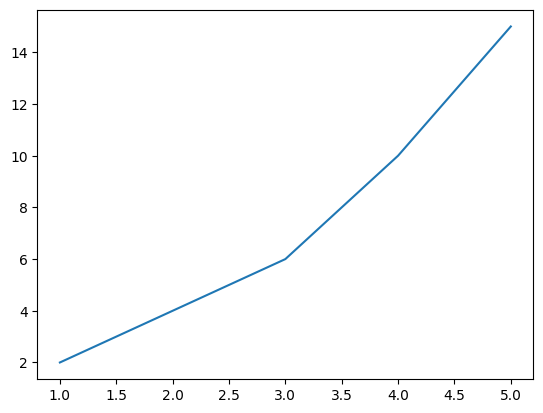

Scatter Plot:  


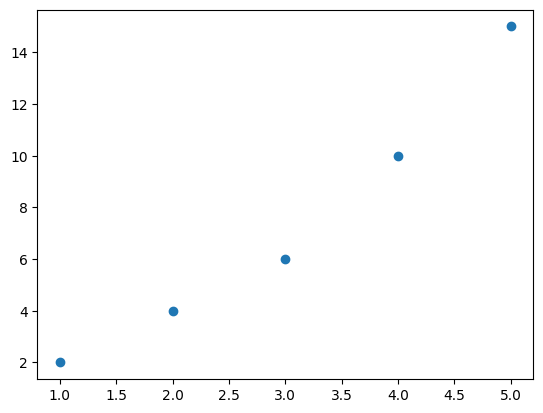

In [ ]:
# reference
# looks like default behavior is adding plot will add plots
# seeming without subplot, fig, or ax

# creating dataframe
df_t = pd.DataFrame({
    'X': [1, 2, 3, 4, 5],
    'Y': [2, 4, 6, 10, 15]
})

# plotting a line graph
print("Line graph: ")
plt.plot(df_t["X"], df_t["Y"])
plt.show()

# plotting a scatter plot
print("Scatter Plot:  ")
plt.scatter(df_t["X"], df_t["Y"])
plt.show()


# 7 Data Checking

https://www.irs.gov/irm/part25/irm_25-007-001

In [37]:
# --- Data Review ----

print (" --- check NTEE_CD ---")
print ("Type: ", df['NTEE_CD'].dtype)
print ("Nulls: ", df['NTEE_CD'].isnull().sum())

# How many are not 3 chars
print ("Check counts by length:\n", df['NTEE_CD'].str.len().value_counts())

#TODO:  Reseach Find the (13) 2 char entries; 12767 4 char entries


 --- check NTEE_CD ---
Type:  object
Nulls:  34139
Check counts by length:
 NTEE_CD
3.0    72846
4.0    12767
2.0       13
Name: count, dtype: int64


In [ ]:
# --- check out cortland that have NTEE Cd

#pd.isna(df['NTEE_CD'])

#filt = (combined_df['NTEE_CD'] == 'Cortland') & (combined_df['StateAbbreviationCd'] == 'NY')
filt =  ~pd.isna(df['NTEE_CD'])

df.loc[filt]



,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
2,10263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0,3,3,2000,194707,1,11,46119030,1,1,202212.0,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...
4,10391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0,3,3,1000,198809,1,16,149319000,1,1,202312.0,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...
5,10426275,ANDROSCOGGIN ALUMNI ASSOCIATION INC,% SKP LLP,601 WEST ST,HARRISON,NY,10528-2508,0,3,3,1000,200609,1,15,0,1,1,202312.0,3,3,2,0,12,82137.0,30865.0,30865.0,B82,NaN,5,(B) Education,Organizations that enable students who demonst...
8,10548911,TSUNIS FAMILY FOUNDATION INC,% JOHN C TSUNIS,2929 EXPRESSWAY DRIVE NORTH,ISLANDIA,NY,11749-0000,0,3,3,1000,200211,1,4,0,1,1,202212.0,4,1,0,1,12,210618.0,5538.0,NaN,T22,NaN,8,"(T) Philanthropy, Voluntarism & Grantmaking Fo...",Private foundations that make grants based on ...
10,10550737,AMERICAN AMATEUR SAMBO FEDERATION INC,% J KOGAN,3111 OCEAN PKWY APT 7C,BROOKLYN,NY,11235-8441,0,3,3,1000,200608,1,15,0,1,1,202312.0,0,0,2,0,12,0.0,0.0,0.0,N70,NaN,10,(N) Recreation & Sports,Organizations that sponsor sports competitions...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0,3,3,1250,202405,1,16,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0,3,3,1200,202405,1,16,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0,3,3,1000,202405,1,15,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0,3,3,1000,202405,1,15,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  int64  
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  int64  
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  int64  
 10  CLASSIFICATION    119765 non-null  int64  
 11  RULING            119765 non-null  int64  
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  int64  
 14  ACTIVITY          119765 non-null  int64  
 15  ORGANIZATION      119765 non-null  int64  
 16  STATUS            11

In [ ]:

print ("Orgs by NTEE Category")
print (df['ntee_cat'].value_counts().sort_index())

print ("\nOrgs by Count in NTEE Category")
print (df['ntee_cat'].value_counts().sort_values())


Orgs by NTEE Category
ntee_cat
(A) Arts, Culture & Humanities                              9821
(B) Education                                               9681
(C) Environment                                             1576
(D) Animal-Related                                          1870
(E) Health Care                                             2898
(F) Mental Health & Crisis Intervention                     1122
(G) Voluntary Health Associations & Medical Disciplines      959
(H) Medical Research                                         504
(I) Crime & Legal-Related                                    771
(J) Employment                                              1220
(K) Food, Agriculture & Nutrition                            893
(L) Housing & Shelter                                       2252
(M) Public Safety, Disaster Preparedness & Relief           1666
(N) Recreation & Sports                                     5083
(O) Youth Development                                      

In [ ]:
# ORGANIZATION: do the lookup tables match the data

print (df.groupby(['ORGANIZATION'])['p_org_id'].count())

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  print (c, ":", bmf['ORGANIZATION'][c] )


# 185 rows with ORGANIZATION code 6 not in lookup

pd.set_option("display.max_columns", 185)

filt = df['ORGANIZATION'] == 6

df.loc[filt]

# TODO: find meaning of org 6 or add to lookup



ORGANIZATION
0      509
1    93760
2     5002
3       60
4        3
5    20246
6      185
Name: p_org_id, dtype: int64
1 : Corporation
2 : Trust
3 : Co-operative
4 : Partnership
5 : Association


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
2534,66035912,HORACE HURLBUTT MEMORIAL FUND TRUST 2815030414,% PEOPLES UNITED BANK,285 DELAWARE AVE FL 2ND,BUFFALO,NY,14202-1812,0,92,3,1000,197012,0,0,928000000,6,12,202312.0,5,4,0,1,12,561656.0,460223.0,NaN,NaN,NaN,2534,no_NTEE,no_ntee
2535,66035931,WESTPORT WESTON FOUNDATION TRUST 2815030753,% PEOPLES UNITED BANK,285 DELAWARE AVE FL 2ND,BUFFALO,NY,14202-1812,0,92,3,1000,197012,0,0,928000000,6,12,202312.0,5,4,0,1,12,648113.0,129546.0,NaN,NaN,NaN,2535,no_NTEE,no_ntee
2558,66233812,CARL CAMPBELL TR FBO ROSCOE LIBRARY,% ORANGE COUNTY TRUST CO,117 GRAND STREET SUITE 100,GOSHEN,NY,10924-1804,0,92,3,1000,0,0,0,909000000,6,12,202403.0,3,3,0,1,3,92773.0,69242.0,NaN,NaN,NaN,2558,no_NTEE,no_ntee
6757,112761787,KIATA INC,% D SULLIVAN & MANNING,2262A CENTRE AVE,BELLMORE,NY,11710-3407,0,91,3,1000,0,0,0,909000000,6,12,NaN,0,3,1,0,12,NaN,NaN,NaN,NaN,NaN,6757,no_NTEE,no_ntee
8743,113067126,FOREIGN & DOMESTIC MISS SOCIETY,NaN,388 GREENWICH ST TAX 19TH FL,NEW YORK,NY,10013-2362,0,92,3,1000,0,0,4,909000000,6,12,202312.0,1,2,0,1,12,9933.0,13308.0,NaN,NaN,NaN,8743,no_NTEE,no_ntee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69885,366756150,J SPENCER & CHRISTINE L STANDISH CHARITABLE TR...,NaN,1 SCHUYLER MEADOW RD,LOUDONVILLE,NY,12211-1423,0,92,3,1000,0,0,0,909000000,6,12,NaN,0,0,0,0,12,NaN,NaN,NaN,NaN,NaN,69885,no_NTEE,no_ntee
83694,510252549,C BAINBRIDGE SMITH FUND UW ALGA LAW BAR ASSOCI...,% CITIBANK NA MARTIN A CRUZ,388 GREENWICH ST TAX 19TH FL,NEW YORK,NY,10013-2362,0,92,3,1000,0,0,0,909000000,6,12,202312.0,6,6,0,1,12,1228684.0,1377736.0,NaN,NaN,NaN,83694,no_NTEE,no_ntee
84653,526025653,EDWIN B PARKER TRUST UW,% COLUMBIA UNIV SCHOOL OF LAW,435 WEST 116TH STREET,NEW YORK,NY,10027-7237,0,91,3,1000,190012,0,0,909000000,6,12,202306.0,8,6,1,0,6,15500048.0,4762174.0,630437.0,NaN,NaN,84653,no_NTEE,no_ntee
84674,526174408,CARL W SCHAFER TRUST UW,% FIRST NATL BK & TR CO OF W MD,626 COMMERCE DRIVE - 3RD FLOOR,AMHERST,NY,14228-2307,0,92,3,1000,0,0,0,909000000,6,12,202312.0,6,4,0,1,12,1438923.0,294971.0,NaN,NaN,NaN,84674,no_NTEE,no_ntee


In [ ]:
# FOUNDATION: do the bmf lookup tables match the data

print (df.groupby(['FOUNDATION'])['p_org_id'].count())

for c in (c for c in bmf['FOUNDATION'] if c != 'define') :
  print (c, ":", bmf['FOUNDATION'][c] )

# codes go to 18, but data has 21 to 24
#TODO: find meanings or just add undefined to lookup


FOUNDATION
0     18204
2        26
3       742
4     12098
7         1
9        49
10    20245
11     1525
12      337
13      135
14       32
15    40836
16    24030
17     1040
18        4
21      332
22       78
23       39
24       12
Name: p_org_id, dtype: int64
0 : All organizations except 501(c)(3)
2 : Private operating foundation exempt from paying excise taxes or investment income
3 : Private operating foundation (other)
4 : Private nonoperating foundation
9 : Suspense
10 : Church
11 : School
12 : Hospital or medical research organization
13 : Organization which operates for benefit of college or university and is owned or operated by a governmental unit
14 : Governmental unit
15 : Organization which receives a substantial part of its support from a governmental unit or the general public
16 : Organization that normally receives no more than one-third of its support from gross investment income and unrelated business income and at the same time more than one-third of its suppo

In [ ]:
# ACCT_PD: do the lookup tables match the data

print (bmf['ACCT_PD']['define'])

print (df.groupby(['ACCT_PD'])['p_org_id'].count())


#for c in (c for c in bmf['ACCT_PD'] if c != 'define') :
#  print (c, ":", bmf['ACCT_PD'][c] )



KeyError: 'ACCT_PD'

## Subsection and Classification

In [ ]:
# check subsection and classification

# https://www.irs.gov/charities-non-profits/other-tax-exempt-organizations

# how many rows have subsection, but no classification?
# how many rows have classification, but no subsection?

print ("Null Subsection: ", df['SUBSECTION'].isnull().sum())

print ("Null CLASSIFICATION: ", df['CLASSIFICATION'].isnull().sum())

# don't believe, but total
#df.groupby(['SUBSECTION', 'CLASSIFICATION']).size()
#df.groupby(['SUBSECTION', 'CLASSIFICATION']).size().sum()


#filt = (df['SUBSECTION'] == 0) # & (df['CLASSIFICATION'] == 1200)
#df.loc[filt]

#filt = (df['SUBSECTION'] == 0)  & (df['CLASSIFICATION'] == '0000')
#df.loc[filt]

filt =  (df['CLASSIFICATION'] == '0000')
df.loc[filt]




Null Subsection:  0
Null CLASSIFICATION:  0


In [ ]:

for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  print (c, ":", bmf['SUBSECTION'][c] )


1 : Corporations Organized Under Act of Congress (including Federal Credit Unions
2 : Title Holding Corporations for Exempt Organization
3 : Charitable Organization
4 : Civic Leagues and Social Welfare Organizations and Local Associations of Employees
5 : Labor, Agricultural and Horticultural Organizations
6 : Business Leagues, etc.
7 : Social and Recreation Clubs
8 : Fraternal Beneficiary Societies
9 : Voluntary Employees' Beneficiary Associations
10 : Domestic Fraternal Societies
11 : Teachers' Retirement Fund Associations
12 : Benevolent Life Insurance Associations, Mutual Ditch or Irrigation Companies, Mutual or Cooperative Telephone Companies, or Like Organizations (if 85 percent or more of the organization's income consists of amounts collected from members for the sole purpose of meeting losses and expenses
13 : Cemetery Companies (owned and operated exclusively for the benefit of their members or which are not operated for profit
14 : State Chartered Credit Unions, Mutual Reser

In [ ]:
# seperate each classification

#c = df[['CLASSIFICATION', 'SUBSECTION']].head(10)

for index, ss, clsfn in df.loc[:, ['SUBSECTION', 'CLASSIFICATION']].head(10).itertuples():
  ss_str = str(ss)
  print ("501c(" + ss_str + ")  " + bmf['SUBSECTION'][ss_str]  )
  # print ("ss: ", ss_str)
  print ("\t classification(s) codes: ", clsfn)

  for each_c in clsfn:
    if each_c == "0":
      break
    ss_class = ss_str + "_" + each_c
    print ("\t\t", bmf['SS_Class'][ss_class])




501c(3)  Charitable Organization
	 classification(s) codes:  1270
		 Charitable Organization
		 Educational Organization
		 Religious Organization
501c(3)  Charitable Organization
	 classification(s) codes:  7000
		 Religious Organization
501c(3)  Charitable Organization
	 classification(s) codes:  2000
		 Educational Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1200
		 Charitable Organization
		 Educational Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(10)  Domestic Fraternal Societies
	 classification(s) codes:  1000
		 Domestic Fraternal Societies Associations
501c(6)  Business Leagues, etc.
	 classification(s) codes:  2000
		 Business League
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(8)  Fraternal Beneficiary Societies
	 classification(s) codes

## Status, Other

In [ ]:
# STATUS: do the lookup tables match the data


df.groupby(['STATUS'])['p_org_id'].count()

#
#for c in (c for c in bmf['STATUS'] if c != 'define') :
#  print (c, ":", bmf['STATUS'][c] )


STATUS
1     119304
2         67
12       314
25        80
Name: p_org_id, dtype: int64

In [ ]:
# FILING_REQ_CD

# FILING_REQ_CD: do the lookup tables match the data

#df.groupby(['FILING_REQ_CD'])['p_org_id'].count()

#
for c in (c for c in bmf['FILING_REQ_CD'] if c != 'define') :
  print (c, ":", bmf['FILING_REQ_CD'][c] )



3 : 990 - Group return
7 : 990 - Government 501(c)(1)
1 : 990 (all other) or 990EZ return
2 : 990 - Not required to file (income less than $25,000)
6 : 990 - Not required to file (church)
13 : 990 - Not required to file (religious organization)
14 : 990 - Not required to file (instrumentalities of states or political subdivisions)
0 : 990 - Not required to file(all other)


In [ ]:
# quick dump of csv to check sums and counts
cortland_df.to_csv('/content/drive/My Drive/irs_data/cortland_geo.csv')

## Formatting

In [ ]:
# Format dollar columns
# https://pbpython.com/styling-pandas.html

format_mapping = {"INCOME_AMT": "${:,.0f}", "REVENUE_AMT": "${:,.0f}", "ASSET_AMT": "${:,.0f}"}

df.style.format(format_mapping)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME
449,10939780,FREE & ACCEPTED MASONS OF NEW YORK,% JASON C TRABUCCO,15 EXCELSIOR ST,CORTLAND,NY,13045-2301,265,10,9,1000,194012,2,0,279036000,5,1,202312.000000,0,0,2,0,12,$0,$0,$0,nan,438 MARATHON LODGE
949,30469943,DISABLED AMERICAN VETERANS AUXILIARY INC,% CAROL WHITMARSH,14813 STATE ROUTE 90,CORTLAND,NY,13045-0000,2473,4,9,1000,197310,1,0,908921000,5,1,202306.000000,0,0,2,0,6,$0,$0,$0,nan,153 CORTLAND MEMORIAL
1285,43658949,SONS OF ITALY IN AMERICA,% STEPHANIE DENSMORE,176 ELM ST,CORTLAND,NY,13045-2322,3610,8,9,1000,194106,2,0,0,5,1,202312.000000,0,0,2,0,12,$0,$0,$0,Z99,1730 STELLA D ORO
14649,115227037,CORTLANDVILLE FIRE DEPARTMENT INCORPORATED,nan,999 NYS ROUTE 13,CORTLAND,NY,13045-3548,0,3,3,1000,198602,1,15,407994000,1,1,202212.000000,4,3,1,0,12,"$220,657","$50,438","$49,043",M24Z,nan
18383,132951986,1890 HOUSE MUSEUM AND CENTER FOR THE ARTS,nan,37 TOMPKINS STREET,CORTLAND,NY,13045-0000,0,3,3,1000,197810,1,15,60000000,1,1,202212.000000,4,3,1,0,12,"$438,205","$74,274","$74,274",A82Z,nan
29419,136162018,AUTOMOTIVE LIFT INSTITUTE INC,nan,3699 LUKER RD,CORTLAND,NY,13045-9397,0,6,3,2000,194611,2,0,403000000,1,1,202312.000000,6,6,1,0,12,"$2,656,368","$2,408,508","$1,605,329",nan,nan
34198,141806291,NEW YORK STATE FALLEN FIRE FIGHTERS MEMORIAL COMMITTEE INC,% JOHN TUCKER,14 JEWETT AVE,CORTLAND,NY,13045-2009,0,3,3,1000,200302,1,15,0,1,1,202404.000000,0,0,2,0,4,$0,$0,$0,A84,nan
35991,150278960,CORTLAND COUNTY CHAMBER OF COMMERCE INC,nan,83 MAIN STREET,CORTLAND,NY,13045-0000,0,6,3,3000,194507,2,0,200000000,1,1,202212.000000,5,5,1,0,12,"$597,489","$551,599","$471,803",nan,nan
35992,150279005,CORTLAND COUNTRY CLUB INC,nan,4514 RTE 281,CORTLAND,NY,13045-8894,0,7,3,1000,194507,2,0,280000000,1,1,202212.000000,4,6,1,0,12,"$348,094","$1,273,111","$1,273,111",nan,nan
35993,150279165,ROTARY INTERNATIONAL,% CLUB PRESIDENT,PO BOX 5248,CORTLAND,NY,13045-5248,573,4,9,3000,195805,2,0,520349200,5,1,202206.000000,0,0,2,0,6,$0,$0,$0,nan,CORTLAND ROTARY CLUB


In [ ]:
# df.loc['Total Inc'] = pd.Series(df['INCOME_AMT'].sum(), index=['INCOME_AMT'])
# df.loc['Total Rev'] = pd.Series(df['REVENUE_AMT'].sum(), index=['REVENUE_AMT'])

format_mapping = {"INCOME_AMT": "${:,.0f}", "REVENUE_AMT": "${:,.0f}", "ASSET_AMT": "${:,.0f}"}

cortland_df.sort_values(by="NAME").style.format(format_mapping)

cortland_df.iloc[:, [1, 3, 4, 24, 25, 26]]


In [ ]:
# Sum Amounts with Formatting


print ("Cortland")
Total_Cort_Inc = cortland_df['INCOME_AMT'].sum()
print ("Cortland Income Amt: ", end='')
ia= locale.currency( Total_Cort_Inc, grouping=True )
print (ia[:-3])


# Total = df['INCOME_AMT'].sum()
Total = cortland_df['REVENUE_AMT'].sum()
print ("Cortland Revenue Amt: ", end='')
ia= locale.currency( Total, grouping=True )
print (ia[:-3])


print ("NY State")
NY_Total_Inc = df['INCOME_AMT'].sum()
ia= locale.currency( NY_Total_Inc, grouping=True )
print ("NY Total Income Amt: ", ia[:-3])


ratio_cort = Total_Cort_Inc / NY_Total_Inc
pct_cort = ratio_cort * 100
print ("Calc Pct: ", pct_cort)

print("Round Calc Pct: ", round(pct_cort,2))

print(f"F format: {ratio_cort:.2%}")


# df.dtypes

# display(df)

# fodder to be deleted

### draft Rank Cities by Income of NPs, series

<Axes: ylabel='CITY'>

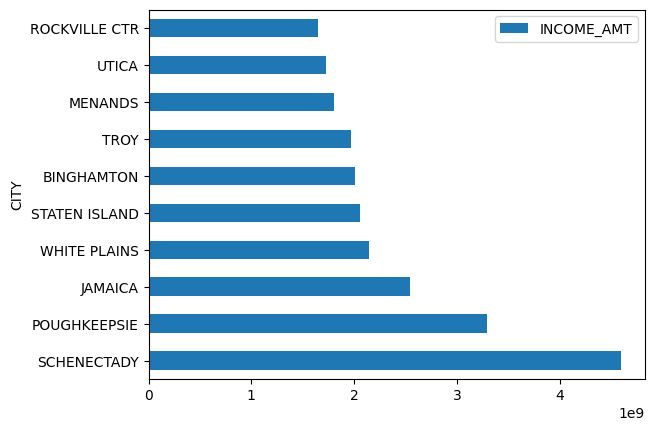

In [ ]:
# Quick draft pandas plot of city incomee

# list of cities by sum of income
# series of income amt with index city

city_inc_ser = df.groupby(['CITY'])['INCOME_AMT'].sum().sort_values(ascending=False)

#df.groupby(['CITY'])['INCOME_AMT'].sum().sort_values(ascending=False).plot.barh(legend=True)

rank_start = 10
rank_end = 20

city_inc_ser.iloc[rank_start:rank_end].plot.barh(legend=True)


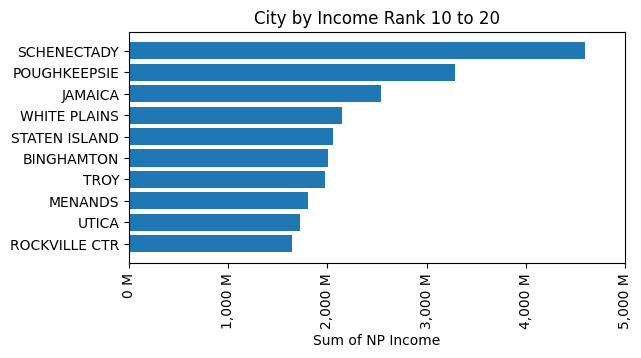

In [ ]:
#  Bar Horizontal of Cities and Sum of Incomes, Ranked

#TODO: Add Rank and enable search for city, return 10 before, after
#TODO: replace wah with city_inc?
from matplotlib.pyplot import figure

label_format =  '{:,.0f} M'

rank_start = 10
rank_end = 20

fig, ax = plt.subplots()
#plt.figure().set_figheight(25)

# sort out fig height depending on how rows being returned
figh = int((rank_end - rank_start) / 3)
fig.set_figheight(figh)

y_pos = np.arange(len(city_inc_df.iloc[rank_start:rank_end].index))
city_inc = city_inc_df.iloc[rank_start:rank_end].values / 1000000

ax.barh(y_pos, city_inc, align='center')
ax.set_yticks(y_pos, labels=city_inc_df.iloc[rank_start:rank_end].index)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)


ax.set_xlabel('Sum of NP Income')
ax.set_title(f'City by Income Rank {rank_start} to {rank_end}')

plt.show()

In [ ]:
# option to load ntee codes into dataframe and do merges

df_ntee = pd.read_csv('/content/drive/My Drive/irs_data/IRS_Code_Lookups/NCCS_NTEE.csv')


# could then convert to dict...
# ntee_dict = pd.to_dict(file)

# for merge, rename NTEE_CD so it matches master file

#df_ntee.rename(columns={'NTEE Code':'NTEE_CD'}, inplace=True)

# display(df_ntee)

filt = df_ntee["NTEE Code"].str.len() ==  1

df_ntee[filt]



In [ ]:
# plot bins -- various code tests


# from stack exchange
# out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
# ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()


# seems to work
#out = cortland_df['NAME'].groupby(pd.cut(cortland_df['INCOME_AMT'], bins))

# out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))

# out.value_counts(sort=False)

# gives count by bins
#out.count()


# out = pd.cut(s, bins=bins, include_lowest=True)
# replace s
out = pd.cut(cortland_df['INCOME_AMT'], bins=bins, include_lowest=True)
#out.count()
#out.value_counts(sort=False)

# works -- but why is there a bracket in there?
out.value_counts().reindex(out.cat.categories)
#print ("out categories")
#print (out.cat.categories)


import re
xlabs = []
# create list for labels?
for c in out.cat.categories:
  h = str(c)
  i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  xlabs.append(i)

# print (xlabs)

#print (xlabs)

#c[1:-1].replace(","," to") for c in out.cat.categories


# -- stack exchange
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()


#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])

# this works
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # works

ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
ax.set_xticklabels(xlabs,rotation=90)
plt.show()


# ax.set_xticklabels(xlabs)
#ax.set_xticklabels(rotation=90)


#ax.get_xticklabels()

# works
#for c in out.cat.categories:
#  print (c)


#[c[1:-1].replace(","," to") for c in out.cat.categories]


#plt.show()


#ax = out.count().plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in bins])
#plt.show()




NameError: name 'bins' is not defined

In [ ]:
# --- fiddle ---
#ntee_cat = [  str(i)[0] if i else 'nan' for i in cortland_df['NTEE_CD']]
#tmp = cortland_df.groupby(ntee_cat)['INCOME_AMT'].sum()

#tmp.plot(legend=True)
#tmp.plot.bar(legend=True)
